# Model training lab

This is the notebook for loading and training models.
Furthermore it provides simple documentation for different approaches used for training a model.

Run the command below to see command-completion on pressing `TAB`.

## Prerequisits

In [1]:
# Imports
import os
import warnings
import tools
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Bidirectional
from matplotlib import pyplot



# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Root CSV files directory
dirname = "./data/"  

# Constant frame count.
frames = 100

## Preparation Stage
### Load data and normalize
For training it's required to extend/reduce every dataset to n frames, where n is `frames`.

In [2]:
listfile = os.listdir(dirname)
data = []
for wordname in listfile:
    if wordname == ".DS_Store":
        continue
    for csv in os.listdir(dirname + wordname):
        filepath = os.path.join(dirname, wordname, csv)
        content = pd.read_csv(filepath, sep=';')
        content = content.reindex(list(range(0, frames)), fill_value=0.0)
        content.fillna(0.0, inplace = True) 
        data.append((wordname, content))


In [3]:
# Print the content of the first dataframe
data[700][0]

'zeigen'

### Split data
Split the dataset up into the following segments:
1. Training Data: 60%
2. Validation Data: 20%
3. Test Data: 20%


In [4]:
features = [n[1] for n in data]
features = [f.to_numpy() for f in features]
labels = [n[0] for n in data]
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.40, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50, random_state=42)

In [5]:
def printCountDataSets(dataset):
    wortCounter = []
    #Liste mit einmaligen Labels erstellen
    labels = sorted(set(dataset), key=dataset.index)
    #Liste nochmal Alphabetisch sortieren
    labels = sorted(labels)
    for label in labels:
        wortCounter.append(0)
    for row in dataset:
        for i in range(len(labels)):
            if str(labels[i]).startswith(row):
                wortCounter[i] += 1
    for i in range(len(labels)):
        print(labels[i], ': ', wortCounter[i], end =";  ")
    print(' ')        
        
print('Alle Klassensätze')
printCountDataSets(labels)
print('Trainings Klassensätze')
printCountDataSets(y_train)
print('Validation Klassensätze')
printCountDataSets(y_val)  
print('Test Klassensätze')
printCountDataSets(y_test) 

Alle Klassensätze
Computer :  57;  Deutschland :  65;  Haben :  68;  Hallo :  57;  Mainz :  65;  Software :  67;  Welt :  66;  du :  66;  ich :  66;  unser :  64;  zeigen :  69;   
Trainings Klassensätze
Computer :  31;  Deutschland :  30;  Haben :  38;  Hallo :  34;  Mainz :  38;  Software :  46;  Welt :  43;  du :  42;  ich :  37;  unser :  43;  zeigen :  44;   
Validation Klassensätze
Computer :  13;  Deutschland :  15;  Haben :  11;  Hallo :  11;  Mainz :  10;  Software :  13;  Welt :  14;  du :  13;  ich :  19;  unser :  10;  zeigen :  13;   
Test Klassensätze
Computer :  13;  Deutschland :  20;  Haben :  19;  Hallo :  12;  Mainz :  17;  Software :  8;  Welt :  9;  du :  11;  ich :  10;  unser :  11;  zeigen :  12;   


In [6]:
# Display data distribution
print("Total:", len(labels))
print("Training:", len(y_train), len(y_train) / len(labels) * 100)
print("Val:", len(y_val), len(y_val) / len(labels) * 100)
print("Test:", len(y_test), len(y_test) / len(labels) * 100)

Total: 710
Training: 426 60.0
Val: 142 20.0
Test: 142 20.0


### Tokenize (One Hot)

In [7]:
tokenizer = tools.tokenize(dirname)
print(tokenizer.word_index)

with open('tokens_json.txt', 'w') as outfile:
    outfile.write(tokenizer.to_json())

encoded_train=tokenizer.texts_to_sequences([y_train])[0]
encoded_val=tokenizer.texts_to_sequences([y_val])[0]
encoded_test=tokenizer.texts_to_sequences([y_test])[0]

y_train = to_categorical(encoded_train)
y_val = to_categorical(encoded_val)
y_test = to_categorical(encoded_test)

print(y_train)

{'computer': 1, 'deutschland': 2, 'du': 3, 'haben': 4, 'hallo': 5, 'ich': 6, 'mainz': 7, 'software': 8, 'unser': 9, 'welt': 10, 'zeigen': 11}
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [8]:
# Making numpy arrays
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val=np.array(x_val)
y_val=np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [46]:
print(x_train)

[[[0.39615  0.398918 0.267371 ... 0.981109 0.505336 0.997934]
  [0.395785 0.39586  0.249782 ... 1.0012   0.500846 1.02185 ]
  [0.397311 0.395266 0.247748 ... 0.954924 0.514182 0.971554]
  ...
  [0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]]

 [[0.374127 0.427507 0.466542 ... 0.       0.       0.      ]
  [0.371845 0.434132 0.453027 ... 0.       0.       0.      ]
  [0.369134 0.440652 0.450106 ... 0.       0.       0.      ]
  ...
  [0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]]

 [[0.441569 0.323025 0.       ... 0.       0.       0.      ]
  [0.442028 0.322752 0.       ... 0.       0.       0.      ]
  [0.440985 0.323315 0.       ... 0.       0.       0.      ]
  ...
  [0.       0.       0.       ... 0.       0.   

## Training Stage
Configure the model and train it.

Metrics:
<div float="right">
    <img src="assets/accuracy.png" width="400"> 
    <img src="assets/precision_recall_formula.png" width="400">
</div>
<img src="assets/precision_recall.png" width="1000">

### Configure model
Configures the model with the specified parameters.

#### LSTM

In [ ]:
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True,
               input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(layers.LSTM(32))  # return a single vector of dimension 32
#model.add(layers.LSTM(16))  # return a single vector of dimension 32
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

### or
#### Bidirectional LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(100, 86)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

### or
#### Simple RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(200, 42)))
model.add(Dense(64, activation="softmax")) #softmax, linear 어떤걸 기준으로 하지
model.add(Dense(128, activation="linear")) #softmax, linear 어떤걸 기준으로 하지
model.add(Dense(21))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### or
#### <span style="color:blue"> Hyperparametertuned LSTM </span>
##### Here it is necessary to install the Keras-Tuner Module by executing:
#####  <span style="color:green"> via Conda:</span>
conda install -c conda-forge keras-tuner
#####  <span style="color:green"> for pip:</span>
pip install keras-tuner


In [37]:
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
from time import time, strftime


starttime= strftime("%Y_%m_%d_%H%M%S")
LOG_DIR = "C:\ML\Optimization_"f"{starttime}" #<-In Windows below Log_dir Path will maybe be too long for Windows to handle, so use a shorter path like this here
#LOG_DIR = "./Optimization_"f"{starttime}" # LOG_DIR holds json files with information and a model of each single trial

def build_model(hp):
    model = Sequential()
    
    model.add(layers.LSTM(hp.Int("LSTM_input", min_value =64, max_value=256,step=64, default=64), #kerastuner will randomly choose a value for nodes between 128 and 256 in steps of 64
                            return_sequences=True,
                            input_shape=(x_train.shape[1], x_train.shape[2])))
    
    for i in range(hp.Int("n_layers" , 1, 3)):    #number of layers ramdom between 1 an 3
        model.add(layers.LSTM(hp.Int(f"LSTM_{i}_units", min_value =64, max_value=256,step=64, default=64),return_sequences=True))
    
    model.add(layers.LSTM(hp.Int(f"LSTM_End", min_value =32, max_value=128,step=32, default=32)))
    model.add(layers.Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model

###   <span style="color:red">Necesarry only in case of using Nvidia GPU  </span>

In [38]:
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs: 1


C:\ProgramData\Anaconda3\envs\tensor-gpu\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Different Keras-Tuner Approaches
### 1 - RandomSearch
Parameter of variables are ranomly used (number of layers, number of nodes) and "best" model is chosen.

In [39]:
tuner  = RandomSearch(
    build_model,     #Function to use search in
    objective = "val_accuracy",  #Chooses "best model" looking for highest value of val_accuracy
    max_trials = 15,       # Number of different combinations tried Nodes and layers
    executions_per_trial = 1, 
    directory = LOG_DIR,
    project_name='SignLagnuageModelOptimization'
    )

#tuner.search_space_summary()

tuner.search(x=x_train,      #syntax just like in fit
                y= y_train,
            epochs=150,
            batch_size=32,
            validation_data=(x_val,y_val))

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())

import winsound
frequency = 500  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 12)                396       
Total params: 172,300
Trainable params: 172,300
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
______________________________

Epoch 8/150
426/426 [==============================] - ETA: 0s - loss: 1.8119 - accuracy: 0.1875 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8188 - accuracy: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8530 - accuracy: 0.1953 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9234 - accuracy: 0.2062 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9234 - accuracy: 0.2009 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9287 - accuracy: 0.1992 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9386 - accuracy: 0.2031 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9443 - accuracy: 0.1960 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9413 - accuracy: 0.2067 - precision: 0.0000e+00 - recall: 0.0000e+0 - 1s 2ms/sample - loss: 1.9390 - accuracy: 0.2066 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8125 - val_accuracy: 0.2042 - val_precision: 0

Epoch 27/150
426/426 [==============================] - ETA: 0s - loss: 1.5189 - accuracy: 0.5312 - precision: 1.0000 - recall: 0.093 - ETA: 0s - loss: 1.5927 - accuracy: 0.4167 - precision: 0.7143 - recall: 0.104 - ETA: 0s - loss: 1.5619 - accuracy: 0.4000 - precision: 0.6000 - recall: 0.093 - ETA: 0s - loss: 1.5741 - accuracy: 0.3884 - precision: 0.6071 - recall: 0.075 - ETA: 0s - loss: 1.5660 - accuracy: 0.4062 - precision: 0.6250 - recall: 0.069 - ETA: 0s - loss: 1.5672 - accuracy: 0.3977 - precision: 0.6579 - recall: 0.071 - ETA: 0s - loss: 1.5556 - accuracy: 0.3942 - precision: 0.7045 - recall: 0.074 - 1s 1ms/sample - loss: 1.5507 - accuracy: 0.3991 - precision: 0.7111 - recall: 0.0751 - val_loss: 1.6012 - val_accuracy: 0.3451 - val_precision: 0.8571 - val_recall: 0.0845
Epoch 28/150
426/426 [==============================] - ETA: 0s - loss: 1.4603 - accuracy: 0.4062 - precision: 1.0000 - recall: 0.093 - ETA: 0s - loss: 1.5006 - accuracy: 0.3646 - precision: 0.8571 - recall: 0.06

426/426 [==============================] - ETA: 0s - loss: 1.3110 - accuracy: 0.4688 - precision: 0.6000 - recall: 0.187 - ETA: 0s - loss: 1.3140 - accuracy: 0.4896 - precision: 0.6522 - recall: 0.156 - ETA: 0s - loss: 1.3086 - accuracy: 0.5125 - precision: 0.7188 - recall: 0.143 - ETA: 0s - loss: 1.3350 - accuracy: 0.4911 - precision: 0.7391 - recall: 0.151 - ETA: 0s - loss: 1.3371 - accuracy: 0.4688 - precision: 0.7419 - recall: 0.159 - ETA: 0s - loss: 1.3657 - accuracy: 0.4517 - precision: 0.7432 - recall: 0.156 - ETA: 0s - loss: 1.3546 - accuracy: 0.4591 - precision: 0.7500 - recall: 0.151 - 1s 1ms/sample - loss: 1.3613 - accuracy: 0.4531 - precision: 0.7500 - recall: 0.1479 - val_loss: 1.4551 - val_accuracy: 0.4014 - val_precision: 0.8667 - val_recall: 0.1831
Epoch 48/150
426/426 [==============================] - ETA: 0s - loss: 1.3130 - accuracy: 0.5312 - precision: 0.7143 - recall: 0.156 - ETA: 0s - loss: 1.3621 - accuracy: 0.5104 - precision: 0.6500 - recall: 0.135 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.6946 - accuracy: 0.4375 - precision: 0.4000 - recall: 0.187 - ETA: 0s - loss: 1.5109 - accuracy: 0.4271 - precision: 0.4375 - recall: 0.218 - ETA: 0s - loss: 1.4601 - accuracy: 0.3938 - precision: 0.4524 - recall: 0.237 - ETA: 0s - loss: 1.4130 - accuracy: 0.4241 - precision: 0.4746 - recall: 0.250 - ETA: 0s - loss: 1.3680 - accuracy: 0.4444 - precision: 0.4968 - recall: 0.270 - ETA: 0s - loss: 1.3646 - accuracy: 0.4631 - precision: 0.5160 - recall: 0.275 - ETA: 0s - loss: 1.3337 - accuracy: 0.4808 - precision: 0.5388 - recall: 0.283 - 1s 1ms/sample - loss: 1.3315 - accuracy: 0.4859 - precision: 0.5442 - recall: 0.2887 - val_loss: 1.4229 - val_accuracy: 0.3873 - val_precision: 0.6061 - val_recall: 0.2817
Epoch 68/150
426/426 [==============================] - ETA: 0s - loss: 0.9696 - accuracy: 0.7188 - precision: 0.7778 - recall: 0.437 - ETA: 0s - loss: 1.2196 - accuracy: 0.5625 - precision: 0.6667 - recall: 0.354 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.4684 - accuracy: 0.4688 - precision: 0.5000 - recall: 0.406 - ETA: 0s - loss: 1.2819 - accuracy: 0.5417 - precision: 0.6133 - recall: 0.479 - ETA: 0s - loss: 1.3517 - accuracy: 0.5375 - precision: 0.5929 - recall: 0.418 - ETA: 0s - loss: 1.3405 - accuracy: 0.5491 - precision: 0.6104 - recall: 0.419 - ETA: 0s - loss: 1.3340 - accuracy: 0.5451 - precision: 0.6257 - recall: 0.406 - ETA: 0s - loss: 1.2976 - accuracy: 0.5483 - precision: 0.6460 - recall: 0.414 - ETA: 0s - loss: 1.3258 - accuracy: 0.5288 - precision: 0.6324 - recall: 0.384 - 1s 1ms/sample - loss: 1.3228 - accuracy: 0.5282 - precision: 0.6332 - recall: 0.3850 - val_loss: 1.4728 - val_accuracy: 0.4225 - val_precision: 0.4737 - val_recall: 0.3169
Epoch 88/150
426/426 [==============================] - ETA: 0s - loss: 1.2332 - accuracy: 0.5312 - precision: 0.6500 - recall: 0.406 - ETA: 0s - loss: 1.2277 - accuracy: 0.4896 - precision: 0.6271 - recall: 0.385 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7812 - precision: 0.8462 - recall: 0.687 - ETA: 0s - loss: 0.7839 - accuracy: 0.7083 - precision: 0.7439 - recall: 0.635 - ETA: 0s - loss: 0.7326 - accuracy: 0.7188 - precision: 0.7836 - recall: 0.656 - ETA: 0s - loss: 0.6957 - accuracy: 0.7321 - precision: 0.8022 - recall: 0.651 - ETA: 0s - loss: 0.6585 - accuracy: 0.7431 - precision: 0.8147 - recall: 0.656 - ETA: 0s - loss: 0.6589 - accuracy: 0.7443 - precision: 0.8099 - recall: 0.653 - ETA: 0s - loss: 0.6857 - accuracy: 0.7332 - precision: 0.8036 - recall: 0.639 - 1s 1ms/sample - loss: 0.6868 - accuracy: 0.7347 - precision: 0.8042 - recall: 0.6362 - val_loss: 0.9184 - val_accuracy: 0.5986 - val_precision: 0.7157 - val_recall: 0.5141
Epoch 108/150
426/426 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8125 - precision: 0.9630 - recall: 0.812 - ETA: 0s - loss: 0.6247 - accuracy: 0.7812 - precision: 0.8553 - recall: 0.677 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.7500 - precision: 0.8148 - recall: 0.687 - ETA: 0s - loss: 0.6369 - accuracy: 0.8021 - precision: 0.8415 - recall: 0.718 - ETA: 0s - loss: 0.6344 - accuracy: 0.7812 - precision: 0.8188 - recall: 0.706 - ETA: 0s - loss: 0.6560 - accuracy: 0.7589 - precision: 0.8021 - recall: 0.687 - ETA: 0s - loss: 0.6179 - accuracy: 0.7604 - precision: 0.8008 - recall: 0.697 - ETA: 0s - loss: 0.6069 - accuracy: 0.7614 - precision: 0.8078 - recall: 0.704 - ETA: 0s - loss: 0.6125 - accuracy: 0.7644 - precision: 0.8072 - recall: 0.704 - 1s 1ms/sample - loss: 0.6153 - accuracy: 0.7629 - precision: 0.8059 - recall: 0.7019 - val_loss: 0.9484 - val_accuracy: 0.6549 - val_precision: 0.6960 - val_recall: 0.6127
Epoch 128/150
426/426 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.8750 - precision: 1.0000 - recall: 0.875 - ETA: 0s - loss: 0.5088 - accuracy: 0.7917 - precision: 0.8313 - recall: 0.718 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 0.8418 - accuracy: 0.6875 - precision: 0.8261 - recall: 0.593 - ETA: 0s - loss: 0.9245 - accuracy: 0.6354 - precision: 0.7344 - recall: 0.489 - ETA: 0s - loss: 0.8918 - accuracy: 0.6687 - precision: 0.7456 - recall: 0.531 - ETA: 0s - loss: 0.8570 - accuracy: 0.6920 - precision: 0.7975 - recall: 0.562 - ETA: 0s - loss: 0.8401 - accuracy: 0.6944 - precision: 0.8109 - recall: 0.566 - ETA: 0s - loss: 0.8688 - accuracy: 0.6761 - precision: 0.8050 - recall: 0.551 - ETA: 0s - loss: 0.8898 - accuracy: 0.6683 - precision: 0.7951 - recall: 0.540 - 1s 1ms/sample - loss: 0.8937 - accuracy: 0.6667 - precision: 0.7958 - recall: 0.5399 - val_loss: 1.2342 - val_accuracy: 0.5704 - val_precision: 0.6091 - val_recall: 0.4718
Epoch 148/150
426/426 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.7500 - precision: 0.7826 - recall: 0.562 - ETA: 0s - loss: 0.7030 - accuracy: 0.7344 - precision: 0.7872 - recall: 0.578 - ETA: 0s 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           82176     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 256)          328704    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 64)           82176     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 944,652
Trainable params: 944,652
Non-trainable params: 0
__________________________________________________

Epoch 9/150
426/426 [==============================] - ETA: 0s - loss: 1.7262 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7314 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8088 - accuracy: 0.2937 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8198 - accuracy: 0.2708 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8500 - accuracy: 0.2578 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8530 - accuracy: 0.2465 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8412 - accuracy: 0.2358 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8354 - accuracy: 0.2332 - precision: 1.0000 - recall: 0.0024        - 1s 2ms/sample - loss: 1.8399 - accuracy: 0.2324 - precision: 1.0000 - recall: 0.0023 - val_loss: 1.9020 - val_accuracy: 0.1972 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/150
426/426 [==============================] - ETA: 

426/426 [==============================] - ETA: 0s - loss: 1.5630 - accuracy: 0.2500 - precision: 0.7500 - recall: 0.093 - ETA: 0s - loss: 1.6390 - accuracy: 0.3438 - precision: 0.7143 - recall: 0.104 - ETA: 0s - loss: 1.5776 - accuracy: 0.3500 - precision: 0.7895 - recall: 0.093 - ETA: 0s - loss: 1.5979 - accuracy: 0.3438 - precision: 0.8000 - recall: 0.071 - ETA: 0s - loss: 1.5787 - accuracy: 0.3785 - precision: 0.8077 - recall: 0.072 - ETA: 0s - loss: 1.5904 - accuracy: 0.3781 - precision: 0.7931 - recall: 0.071 - ETA: 0s - loss: 1.5968 - accuracy: 0.3568 - precision: 0.7812 - recall: 0.065 - 1s 2ms/sample - loss: 1.5923 - accuracy: 0.3568 - precision: 0.7568 - recall: 0.0657 - val_loss: 1.5835 - val_accuracy: 0.3521 - val_precision: 0.8235 - val_recall: 0.0986
Epoch 29/150
426/426 [==============================] - ETA: 0s - loss: 1.3532 - accuracy: 0.5000 - precision: 1.0000 - recall: 0.156 - ETA: 0s - loss: 1.5782 - accuracy: 0.3854 - precision: 0.7500 - recall: 0.093 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.1967 - accuracy: 0.5938 - precision: 1.0000 - recall: 0.250 - ETA: 0s - loss: 1.4930 - accuracy: 0.4167 - precision: 0.6765 - recall: 0.239 - ETA: 0s - loss: 1.6311 - accuracy: 0.3812 - precision: 0.6200 - recall: 0.193 - ETA: 0s - loss: 1.7070 - accuracy: 0.3348 - precision: 0.5067 - recall: 0.169 - ETA: 0s - loss: 1.7259 - accuracy: 0.3299 - precision: 0.4894 - recall: 0.159 - ETA: 0s - loss: 1.7517 - accuracy: 0.3295 - precision: 0.4775 - recall: 0.150 - ETA: 0s - loss: 1.7605 - accuracy: 0.3221 - precision: 0.4688 - recall: 0.144 - 1s 2ms/sample - loss: 1.7600 - accuracy: 0.3216 - precision: 0.4688 - recall: 0.1408 - val_loss: 1.6663 - val_accuracy: 0.3099 - val_precision: 0.5000 - val_recall: 0.0352
Epoch 49/150
426/426 [==============================] - ETA: 0s - loss: 1.9045 - accuracy: 0.3125 - precision: 0.5000 - recall: 0.031 - ETA: 0s - loss: 1.7221 - accuracy: 0.3646 - precision: 0.6667 - recall: 0.020 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.5989 - accuracy: 0.3438 - precision: 0.5000 - recall: 0.062 - ETA: 0s - loss: 1.4781 - accuracy: 0.3854 - precision: 0.6429 - recall: 0.093 - ETA: 0s - loss: 1.4849 - accuracy: 0.3875 - precision: 0.6000 - recall: 0.093 - ETA: 0s - loss: 1.4787 - accuracy: 0.4107 - precision: 0.6341 - recall: 0.116 - ETA: 0s - loss: 1.5012 - accuracy: 0.4028 - precision: 0.6207 - recall: 0.125 - ETA: 0s - loss: 1.4895 - accuracy: 0.3977 - precision: 0.6377 - recall: 0.125 - ETA: 0s - loss: 1.5058 - accuracy: 0.4014 - precision: 0.6438 - recall: 0.113 - 1s 2ms/sample - loss: 1.5153 - accuracy: 0.3967 - precision: 0.6486 - recall: 0.1127 - val_loss: 1.5739 - val_accuracy: 0.3662 - val_precision: 0.8750 - val_recall: 0.0986
Epoch 69/150
426/426 [==============================] - ETA: 0s - loss: 1.5123 - accuracy: 0.3438 - precision: 0.5000 - recall: 0.031 - ETA: 0s - loss: 1.5865 - accuracy: 0.3333 - precision: 0.7500 - recall: 0.062 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.4829 - accuracy: 0.4688 - precision: 0.6667 - recall: 0.187 - ETA: 0s - loss: 1.2088 - accuracy: 0.5000 - precision: 0.7714 - recall: 0.281 - ETA: 0s - loss: 1.2762 - accuracy: 0.4922 - precision: 0.7200 - recall: 0.281 - ETA: 0s - loss: 1.3150 - accuracy: 0.4740 - precision: 0.6842 - recall: 0.270 - ETA: 0s - loss: 1.3667 - accuracy: 0.4492 - precision: 0.6633 - recall: 0.253 - ETA: 0s - loss: 1.3628 - accuracy: 0.4625 - precision: 0.6560 - recall: 0.256 - ETA: 0s - loss: 1.3414 - accuracy: 0.4714 - precision: 0.6579 - recall: 0.260 - 1s 2ms/sample - loss: 1.3126 - accuracy: 0.4836 - precision: 0.6667 - recall: 0.2723 - val_loss: 1.6105 - val_accuracy: 0.3662 - val_precision: 0.4627 - val_recall: 0.2183
Epoch 89/150
426/426 [==============================] - ETA: 0s - loss: 1.4540 - accuracy: 0.4688 - precision: 0.5833 - recall: 0.218 - ETA: 0s - loss: 1.3421 - accuracy: 0.5208 - precision: 0.5897 - recall: 0.239 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.1570 - accuracy: 0.5625 - precision: 0.6000 - recall: 0.281 - ETA: 0s - loss: 1.0700 - accuracy: 0.5625 - precision: 0.6078 - recall: 0.322 - ETA: 0s - loss: 1.0214 - accuracy: 0.5859 - precision: 0.6667 - recall: 0.343 - ETA: 0s - loss: 1.0100 - accuracy: 0.6146 - precision: 0.7200 - recall: 0.375 - ETA: 0s - loss: 1.0390 - accuracy: 0.5938 - precision: 0.6934 - recall: 0.371 - ETA: 0s - loss: 1.0323 - accuracy: 0.5844 - precision: 0.6959 - recall: 0.371 - ETA: 0s - loss: 1.0638 - accuracy: 0.5703 - precision: 0.7079 - recall: 0.372 - 1s 2ms/sample - loss: 1.0622 - accuracy: 0.5845 - precision: 0.7257 - recall: 0.3850 - val_loss: 1.4032 - val_accuracy: 0.5000 - val_precision: 0.5846 - val_recall: 0.2676
Epoch 109/150
426/426 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.5625 - precision: 0.5882 - recall: 0.312 - ETA: 0s - loss: 1.0275 - accuracy: 0.6250 - precision: 0.7500 - recall: 0.406 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 0.7917 - accuracy: 0.6875 - precision: 0.8333 - recall: 0.625 - ETA: 0s - loss: 0.9346 - accuracy: 0.5938 - precision: 0.7576 - recall: 0.520 - ETA: 0s - loss: 0.8737 - accuracy: 0.6062 - precision: 0.7391 - recall: 0.531 - ETA: 0s - loss: 0.8840 - accuracy: 0.5938 - precision: 0.7278 - recall: 0.513 - ETA: 0s - loss: 0.9026 - accuracy: 0.6042 - precision: 0.7238 - recall: 0.527 - ETA: 0s - loss: 0.8734 - accuracy: 0.6222 - precision: 0.7297 - recall: 0.536 - ETA: 0s - loss: 0.8772 - accuracy: 0.6226 - precision: 0.7134 - recall: 0.526 - 1s 2ms/sample - loss: 0.8651 - accuracy: 0.6291 - precision: 0.7206 - recall: 0.5329 - val_loss: 1.2801 - val_accuracy: 0.5282 - val_precision: 0.5842 - val_recall: 0.4155
Epoch 129/150
426/426 [==============================] - ETA: 0s - loss: 0.8527 - accuracy: 0.6250 - precision: 0.7391 - recall: 0.531 - ETA: 0s - loss: 0.8535 - accuracy: 0.6458 - precision: 0.7424 - recall: 0.510 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.6875 - precision: 0.7200 - recall: 0.562 - ETA: 0s - loss: 0.7191 - accuracy: 0.6771 - precision: 0.7308 - recall: 0.593 - ETA: 0s - loss: 0.7775 - accuracy: 0.6875 - precision: 0.7500 - recall: 0.600 - ETA: 0s - loss: 0.7399 - accuracy: 0.6920 - precision: 0.7611 - recall: 0.611 - ETA: 0s - loss: 0.7327 - accuracy: 0.7014 - precision: 0.7686 - recall: 0.611 - ETA: 0s - loss: 0.7323 - accuracy: 0.7017 - precision: 0.7606 - recall: 0.613 - ETA: 0s - loss: 0.7268 - accuracy: 0.7043 - precision: 0.7566 - recall: 0.620 - 1s 2ms/sample - loss: 0.7311 - accuracy: 0.7066 - precision: 0.7564 - recall: 0.6197 - val_loss: 1.2180 - val_accuracy: 0.5915 - val_precision: 0.6423 - val_recall: 0.5563
Epoch 149/150
426/426 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.8125 - precision: 0.8621 - recall: 0.781 - ETA: 0s - loss: 0.5915 - accuracy: 0.8125 - precision: 0.8434 - recall: 0.729 - ETA: 0s 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 192)          246528    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                28800     
_________________________________________________________________
dense (Dense)                (None, 12)                396       
Total params: 385,804
Trainable params: 385,804
Non-trainable params: 0
_________________________________________________________________
Train on 426 samples, validate on 142 samples
Epoch 1/150
426/426 [==============================] - ETA: 50s - loss: 2.4841 - accuracy: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+ - ETA: 14s - loss: 2.4671 - accuracy: 0.1458 - precision: 0.0

426/426 [==============================] - ETA: 0s - loss: 1.7927 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8515 - accuracy: 0.1979 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8368 - accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8667 - accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8534 - accuracy: 0.2326 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8734 - accuracy: 0.2159 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8585 - accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+0 - 0s 1ms/sample - loss: 1.8611 - accuracy: 0.2160 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8516 - val_accuracy: 0.1901 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 19/150
426/426 [==============================] - ETA: 0s - loss: 1.9028 - accuracy: 0.1250 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.6014 - accuracy: 0.4062 - precision: 1.0000 - recall: 0.093 - ETA: 0s - loss: 1.6185 - accuracy: 0.3333 - precision: 0.8571 - recall: 0.062 - ETA: 0s - loss: 1.5878 - accuracy: 0.3625 - precision: 0.8889 - recall: 0.050 - ETA: 0s - loss: 1.5976 - accuracy: 0.3705 - precision: 0.6471 - recall: 0.049 - ETA: 0s - loss: 1.6019 - accuracy: 0.3542 - precision: 0.6207 - recall: 0.062 - ETA: 0s - loss: 1.5814 - accuracy: 0.3608 - precision: 0.6053 - recall: 0.065 - ETA: 0s - loss: 1.5819 - accuracy: 0.3630 - precision: 0.5745 - recall: 0.064 - 0s 1ms/sample - loss: 1.5752 - accuracy: 0.3638 - precision: 0.5745 - recall: 0.0634 - val_loss: 1.7192 - val_accuracy: 0.3028 - val_precision: 0.8333 - val_recall: 0.1056
Epoch 38/150
426/426 [==============================] - ETA: 0s - loss: 1.5218 - accuracy: 0.3750 - precision: 1.0000 - recall: 0.093 - ETA: 0s - loss: 1.5923 - accuracy: 0.3229 - precision: 0.7692 - recall: 0.104 - ETA: 0s -

Epoch 57/150
426/426 [==============================] - ETA: 0s - loss: 1.5361 - accuracy: 0.2500 - precision: 1.0000 - recall: 0.031 - ETA: 0s - loss: 1.4222 - accuracy: 0.4062 - precision: 0.6667 - recall: 0.062 - ETA: 0s - loss: 1.5931 - accuracy: 0.3625 - precision: 0.5385 - recall: 0.043 - ETA: 0s - loss: 1.5597 - accuracy: 0.3839 - precision: 0.5294 - recall: 0.040 - ETA: 0s - loss: 1.5285 - accuracy: 0.4028 - precision: 0.5714 - recall: 0.041 - ETA: 0s - loss: 1.4971 - accuracy: 0.4375 - precision: 0.5926 - recall: 0.045 - ETA: 0s - loss: 1.4736 - accuracy: 0.4471 - precision: 0.6071 - recall: 0.040 - 1s 1ms/sample - loss: 1.4642 - accuracy: 0.4507 - precision: 0.6071 - recall: 0.0399 - val_loss: 1.5152 - val_accuracy: 0.3310 - val_precision: 0.8333 - val_recall: 0.0352
Epoch 58/150
426/426 [==============================] - ETA: 0s - loss: 1.4974 - accuracy: 0.4375 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.5452 - accuracy: 0.4375 - precision: 1.0000 - reca

426/426 [==============================] - ETA: 0s - loss: 1.1945 - accuracy: 0.5312 - precision: 0.7778 - recall: 0.218 - ETA: 0s - loss: 1.1590 - accuracy: 0.5417 - precision: 0.7500 - recall: 0.250 - ETA: 0s - loss: 1.1898 - accuracy: 0.5250 - precision: 0.6923 - recall: 0.225 - ETA: 0s - loss: 1.2185 - accuracy: 0.5089 - precision: 0.6400 - recall: 0.214 - ETA: 0s - loss: 1.2509 - accuracy: 0.5035 - precision: 0.6495 - recall: 0.218 - ETA: 0s - loss: 1.2242 - accuracy: 0.5227 - precision: 0.6694 - recall: 0.230 - ETA: 0s - loss: 1.2209 - accuracy: 0.5312 - precision: 0.6966 - recall: 0.242 - 0s 1ms/sample - loss: 1.2272 - accuracy: 0.5305 - precision: 0.6913 - recall: 0.2418 - val_loss: 1.3522 - val_accuracy: 0.4437 - val_precision: 0.6800 - val_recall: 0.2394
Epoch 78/150
426/426 [==============================] - ETA: 0s - loss: 1.3458 - accuracy: 0.5312 - precision: 0.6667 - recall: 0.250 - ETA: 0s - loss: 1.3048 - accuracy: 0.5000 - precision: 0.5909 - recall: 0.270 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 0.8770 - accuracy: 0.6562 - precision: 0.8421 - recall: 0.500 - ETA: 0s - loss: 0.9007 - accuracy: 0.6875 - precision: 0.8750 - recall: 0.510 - ETA: 0s - loss: 0.9247 - accuracy: 0.6375 - precision: 0.8409 - recall: 0.462 - ETA: 0s - loss: 0.9233 - accuracy: 0.6250 - precision: 0.8583 - recall: 0.459 - ETA: 0s - loss: 0.9302 - accuracy: 0.6354 - precision: 0.8506 - recall: 0.454 - ETA: 0s - loss: 0.8975 - accuracy: 0.6449 - precision: 0.8549 - recall: 0.468 - ETA: 0s - loss: 0.9055 - accuracy: 0.6466 - precision: 0.8419 - recall: 0.473 - 0s 1ms/sample - loss: 0.8994 - accuracy: 0.6479 - precision: 0.8430 - recall: 0.4789 - val_loss: 1.2089 - val_accuracy: 0.5000 - val_precision: 0.6835 - val_recall: 0.3803
Epoch 98/150
426/426 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.6250 - precision: 0.7500 - recall: 0.468 - ETA: 0s - loss: 0.8353 - accuracy: 0.6562 - precision: 0.8182 - recall: 0.562 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.7812 - precision: 0.7692 - recall: 0.625 - ETA: 0s - loss: 0.6146 - accuracy: 0.7812 - precision: 0.8182 - recall: 0.703 - ETA: 0s - loss: 0.6556 - accuracy: 0.7422 - precision: 0.7890 - recall: 0.671 - ETA: 0s - loss: 0.6428 - accuracy: 0.7656 - precision: 0.8062 - recall: 0.671 - ETA: 0s - loss: 0.6423 - accuracy: 0.7578 - precision: 0.8230 - recall: 0.671 - ETA: 0s - loss: 0.6472 - accuracy: 0.7563 - precision: 0.8327 - recall: 0.684 - ETA: 0s - loss: 0.6704 - accuracy: 0.7500 - precision: 0.8217 - recall: 0.671 - 0s 1ms/sample - loss: 0.7013 - accuracy: 0.7394 - precision: 0.8081 - recall: 0.6526 - val_loss: 1.0950 - val_accuracy: 0.5845 - val_precision: 0.6316 - val_recall: 0.5070
Epoch 118/150
426/426 [==============================] - ETA: 0s - loss: 0.7619 - accuracy: 0.7812 - precision: 0.8519 - recall: 0.718 - ETA: 0s - loss: 0.6296 - accuracy: 0.8021 - precision: 0.8701 - recall: 0.697 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 0.9171 - accuracy: 0.6562 - precision: 0.6667 - recall: 0.500 - ETA: 0s - loss: 0.7520 - accuracy: 0.7500 - precision: 0.7922 - recall: 0.635 - ETA: 0s - loss: 0.7274 - accuracy: 0.7375 - precision: 0.8031 - recall: 0.637 - ETA: 0s - loss: 0.7468 - accuracy: 0.7277 - precision: 0.7857 - recall: 0.638 - ETA: 0s - loss: 0.7323 - accuracy: 0.7500 - precision: 0.8018 - recall: 0.631 - ETA: 0s - loss: 0.7073 - accuracy: 0.7528 - precision: 0.8129 - recall: 0.642 - ETA: 0s - loss: 0.6847 - accuracy: 0.7524 - precision: 0.8221 - recall: 0.644 - 0s 1ms/sample - loss: 0.6788 - accuracy: 0.7559 - precision: 0.8263 - recall: 0.6479 - val_loss: 1.1064 - val_accuracy: 0.5986 - val_precision: 0.6636 - val_recall: 0.5141
Epoch 138/150
426/426 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.8438 - precision: 0.9200 - recall: 0.718 - ETA: 0s - loss: 0.5343 - accuracy: 0.8542 - precision: 0.9241 - recall: 0.760 - ETA: 0s 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 192)          246528    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                65792     
_________________________________________________________________
dense (Dense)                (None, 12)                780       
Total params: 554,764
Trainable params: 554,764
Non-trainable params: 0
_________________________________________________________________
Train on 426 samples, validate on 142 samples
Epoch 1/150
426/426 [==============================] - ETA: 1:14 - los

Epoch 19/150
426/426 [==============================] - ETA: 0s - loss: 1.6903 - accuracy: 0.3125 - precision: 0.6000 - recall: 0.093 - ETA: 0s - loss: 1.8449 - accuracy: 0.2917 - precision: 0.4545 - recall: 0.052 - ETA: 0s - loss: 1.7804 - accuracy: 0.3375 - precision: 0.4211 - recall: 0.050 - ETA: 0s - loss: 1.7366 - accuracy: 0.3348 - precision: 0.5333 - recall: 0.071 - ETA: 0s - loss: 1.7300 - accuracy: 0.3368 - precision: 0.5366 - recall: 0.076 - ETA: 0s - loss: 1.7051 - accuracy: 0.3494 - precision: 0.5686 - recall: 0.082 - ETA: 0s - loss: 1.6798 - accuracy: 0.3510 - precision: 0.5645 - recall: 0.084 - 1s 1ms/sample - loss: 1.6821 - accuracy: 0.3498 - precision: 0.5625 - recall: 0.0845 - val_loss: 1.7538 - val_accuracy: 0.3310 - val_precision: 0.6190 - val_recall: 0.0915
Epoch 20/150
426/426 [==============================] - ETA: 0s - loss: 1.4368 - accuracy: 0.5312 - precision: 0.6667 - recall: 0.125 - ETA: 0s - loss: 1.5483 - accuracy: 0.3854 - precision: 0.6957 - recall: 0.16

426/426 [==============================] - ETA: 0s - loss: 1.8478 - accuracy: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9440 - accuracy: 0.2083 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9568 - accuracy: 0.1937 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9173 - accuracy: 0.1830 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9103 - accuracy: 0.1944 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9303 - accuracy: 0.2131 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9222 - accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+0 - 1s 1ms/sample - loss: 1.9145 - accuracy: 0.2183 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8583 - val_accuracy: 0.2606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/150
426/426 [==============================] - ETA: 0s - loss: 1.9907 - accuracy: 0.1875 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.5613 - accuracy: 0.2812 - precision: 1.0000 - recall: 0.031 - ETA: 0s - loss: 1.6352 - accuracy: 0.3021 - precision: 1.0000 - recall: 0.010 - ETA: 0s - loss: 1.6946 - accuracy: 0.2875 - precision: 1.0000 - recall: 0.006 - ETA: 0s - loss: 1.7025 - accuracy: 0.2857 - precision: 1.0000 - recall: 0.004 - ETA: 0s - loss: 1.7107 - accuracy: 0.2882 - precision: 1.0000 - recall: 0.006 - ETA: 0s - loss: 1.7343 - accuracy: 0.2841 - precision: 1.0000 - recall: 0.011 - ETA: 0s - loss: 1.7418 - accuracy: 0.2861 - precision: 1.0000 - recall: 0.014 - 1s 1ms/sample - loss: 1.7359 - accuracy: 0.2840 - precision: 1.0000 - recall: 0.0164 - val_loss: 1.7140 - val_accuracy: 0.2746 - val_precision: 0.6667 - val_recall: 0.0563
Epoch 56/150
426/426 [==============================] - ETA: 0s - loss: 1.6042 - accuracy: 0.3750 - precision: 1.0000 - recall: 0.062 - ETA: 0s - loss: 1.7114 - accuracy: 0.3438 - precision: 0.5385 - recall: 0.072 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.6080 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6015 - accuracy: 0.3542 - precision: 1.0000 - recall: 0.0208        - ETA: 0s - loss: 1.5982 - accuracy: 0.3375 - precision: 0.8333 - recall: 0.031 - ETA: 0s - loss: 1.6719 - accuracy: 0.3304 - precision: 0.8889 - recall: 0.035 - ETA: 0s - loss: 1.7125 - accuracy: 0.3203 - precision: 0.8889 - recall: 0.031 - ETA: 0s - loss: 1.7174 - accuracy: 0.3125 - precision: 0.9167 - recall: 0.034 - ETA: 0s - loss: 1.7401 - accuracy: 0.3047 - precision: 0.9375 - recall: 0.039 - 1s 1ms/sample - loss: 1.7178 - accuracy: 0.3052 - precision: 0.8571 - recall: 0.0423 - val_loss: 1.6078 - val_accuracy: 0.3169 - val_precision: 0.6842 - val_recall: 0.0915
Epoch 76/150
426/426 [==============================] - ETA: 0s - loss: 1.7421 - accuracy: 0.3438 - precision: 0.4286 - recall: 0.093 - ETA: 0s - loss: 1.8192 - accuracy: 0.2812 - precision: 0.4737 - recall: 0

426/426 [==============================] - ETA: 0s - loss: 1.4609 - accuracy: 0.5312 - precision: 0.8571 - recall: 0.187 - ETA: 0s - loss: 1.2733 - accuracy: 0.4896 - precision: 0.7143 - recall: 0.208 - ETA: 0s - loss: 1.3037 - accuracy: 0.4750 - precision: 0.7209 - recall: 0.193 - ETA: 0s - loss: 1.3118 - accuracy: 0.4509 - precision: 0.7119 - recall: 0.187 - ETA: 0s - loss: 1.3603 - accuracy: 0.4410 - precision: 0.6806 - recall: 0.170 - ETA: 0s - loss: 1.3388 - accuracy: 0.4716 - precision: 0.7093 - recall: 0.173 - ETA: 0s - loss: 1.3324 - accuracy: 0.4639 - precision: 0.7292 - recall: 0.168 - 1s 1ms/sample - loss: 1.3259 - accuracy: 0.4695 - precision: 0.7320 - recall: 0.1667 - val_loss: 1.4532 - val_accuracy: 0.3732 - val_precision: 0.7500 - val_recall: 0.1690
Epoch 96/150
426/426 [==============================] - ETA: 0s - loss: 1.4816 - accuracy: 0.4062 - precision: 0.5000 - recall: 0.093 - ETA: 0s - loss: 1.3776 - accuracy: 0.4688 - precision: 0.7143 - recall: 0.156 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.0645 - accuracy: 0.5625 - precision: 0.7222 - recall: 0.406 - ETA: 0s - loss: 0.9851 - accuracy: 0.6250 - precision: 0.8182 - recall: 0.421 - ETA: 0s - loss: 1.1160 - accuracy: 0.6094 - precision: 0.6986 - recall: 0.398 - ETA: 0s - loss: 1.1077 - accuracy: 0.5938 - precision: 0.6989 - recall: 0.406 - ETA: 0s - loss: 1.0711 - accuracy: 0.6071 - precision: 0.6970 - recall: 0.410 - ETA: 0s - loss: 1.0706 - accuracy: 0.6042 - precision: 0.6826 - recall: 0.395 - ETA: 0s - loss: 1.0641 - accuracy: 0.6094 - precision: 0.6813 - recall: 0.387 - ETA: 0s - loss: 1.0477 - accuracy: 0.6193 - precision: 0.6829 - recall: 0.397 - ETA: 0s - loss: 1.0508 - accuracy: 0.6178 - precision: 0.6851 - recall: 0.387 - 1s 3ms/sample - loss: 1.0508 - accuracy: 0.6150 - precision: 0.6888 - recall: 0.3897 - val_loss: 1.2039 - val_accuracy: 0.5563 - val_precision: 0.6757 - val_recall: 0.3521
Epoch 115/150
426/426 [==============================] - ETA: 0s 

Epoch 124/150
426/426 [==============================] - ETA: 0s - loss: 0.8976 - accuracy: 0.6875 - precision: 0.8000 - recall: 0.500 - ETA: 0s - loss: 0.9337 - accuracy: 0.6771 - precision: 0.7368 - recall: 0.583 - ETA: 0s - loss: 0.9215 - accuracy: 0.6750 - precision: 0.7438 - recall: 0.562 - ETA: 0s - loss: 0.9421 - accuracy: 0.6607 - precision: 0.7484 - recall: 0.531 - ETA: 0s - loss: 0.9409 - accuracy: 0.6493 - precision: 0.7295 - recall: 0.524 - ETA: 0s - loss: 0.9326 - accuracy: 0.6562 - precision: 0.7350 - recall: 0.537 - ETA: 0s - loss: 0.9277 - accuracy: 0.6562 - precision: 0.7359 - recall: 0.544 - 1s 1ms/sample - loss: 0.9435 - accuracy: 0.6455 - precision: 0.7224 - recall: 0.5376 - val_loss: 1.3002 - val_accuracy: 0.5000 - val_precision: 0.5596 - val_recall: 0.4296
Epoch 125/150
426/426 [==============================] - ETA: 0s - loss: 0.8843 - accuracy: 0.6875 - precision: 0.7500 - recall: 0.562 - ETA: 0s - loss: 1.0944 - accuracy: 0.6250 - precision: 0.6486 - recall: 0.

426/426 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.8125 - precision: 0.9286 - recall: 0.812 - ETA: 0s - loss: 0.6259 - accuracy: 0.7917 - precision: 0.8734 - recall: 0.718 - ETA: 0s - loss: 0.6953 - accuracy: 0.7625 - precision: 0.8296 - recall: 0.700 - ETA: 0s - loss: 0.6962 - accuracy: 0.7679 - precision: 0.8316 - recall: 0.705 - ETA: 0s - loss: 0.6994 - accuracy: 0.7639 - precision: 0.8211 - recall: 0.701 - ETA: 0s - loss: 0.7173 - accuracy: 0.7557 - precision: 0.8026 - recall: 0.693 - ETA: 0s - loss: 0.7322 - accuracy: 0.7404 - precision: 0.7966 - recall: 0.677 - 1s 1ms/sample - loss: 0.7296 - accuracy: 0.7418 - precision: 0.7989 - recall: 0.6808 - val_loss: 1.2627 - val_accuracy: 0.5634 - val_precision: 0.5897 - val_recall: 0.4859
Epoch 145/150
426/426 [==============================] - ETA: 0s - loss: 0.7193 - accuracy: 0.7188 - precision: 0.7037 - recall: 0.593 - ETA: 0s - loss: 0.7472 - accuracy: 0.7396 - precision: 0.7442 - recall: 0.666 - ETA: 0s 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 256)          394240    
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                135552    
_________________________________________________________________
dense (Dense)                (None, 12)                1164      
Total params: 1,079,308
Trainable params: 1,079,308
Non-trainable params: 0
_________________________________________________________________
Train on 426 samples, validate on 142 samples
Epoch 1/150
426/426 [==============================] - ETA: 1:19 -

426/426 [==============================] - ETA: 0s - loss: 1.6535 - accuracy: 0.3750 - precision: 1.0000 - recall: 0.093 - ETA: 0s - loss: 1.7461 - accuracy: 0.3333 - precision: 1.0000 - recall: 0.041 - ETA: 0s - loss: 1.7295 - accuracy: 0.3000 - precision: 0.6000 - recall: 0.037 - ETA: 0s - loss: 1.6781 - accuracy: 0.3170 - precision: 0.7778 - recall: 0.062 - ETA: 0s - loss: 1.6891 - accuracy: 0.3229 - precision: 0.7000 - recall: 0.072 - ETA: 0s - loss: 1.7077 - accuracy: 0.3239 - precision: 0.5625 - recall: 0.076 - ETA: 0s - loss: 1.7299 - accuracy: 0.3245 - precision: 0.5079 - recall: 0.076 - 1s 2ms/sample - loss: 1.7301 - accuracy: 0.3216 - precision: 0.4923 - recall: 0.0751 - val_loss: 1.6061 - val_accuracy: 0.3451 - val_precision: 0.6923 - val_recall: 0.1268
Epoch 20/150
426/426 [==============================] - ETA: 0s - loss: 2.0521 - accuracy: 0.2188 - precision: 0.1111 - recall: 0.031 - ETA: 0s - loss: 1.7345 - accuracy: 0.2917 - precision: 0.4545 - recall: 0.104 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.1796 - accuracy: 0.5625 - precision: 1.0000 - recall: 0.187 - ETA: 0s - loss: 1.3326 - accuracy: 0.5156 - precision: 0.9000 - recall: 0.140 - ETA: 0s - loss: 1.4072 - accuracy: 0.4479 - precision: 0.7857 - recall: 0.114 - ETA: 0s - loss: 1.4411 - accuracy: 0.4531 - precision: 0.7222 - recall: 0.101 - ETA: 0s - loss: 1.4715 - accuracy: 0.4479 - precision: 0.8000 - recall: 0.104 - ETA: 0s - loss: 1.4938 - accuracy: 0.4141 - precision: 0.7879 - recall: 0.101 - ETA: 0s - loss: 1.4939 - accuracy: 0.4097 - precision: 0.7941 - recall: 0.093 - ETA: 0s - loss: 1.4856 - accuracy: 0.4219 - precision: 0.8108 - recall: 0.093 - ETA: 0s - loss: 1.4925 - accuracy: 0.4148 - precision: 0.7857 - recall: 0.093 - ETA: 0s - loss: 1.5319 - accuracy: 0.3870 - precision: 0.7708 - recall: 0.088 - 1s 2ms/sample - loss: 1.5281 - accuracy: 0.3826 - precision: 0.7755 - recall: 0.0892 - val_loss: 1.5240 - val_accuracy: 0.3803 - val_precision: 0.8182 - val_

426/426 [==============================] - ETA: 0s - loss: 1.5402 - accuracy: 0.3438 - precision: 0.5833 - recall: 0.218 - ETA: 0s - loss: 1.5684 - accuracy: 0.3438 - precision: 0.5000 - recall: 0.187 - ETA: 0s - loss: 1.4304 - accuracy: 0.4187 - precision: 0.5254 - recall: 0.193 - ETA: 0s - loss: 1.4367 - accuracy: 0.4062 - precision: 0.5309 - recall: 0.192 - ETA: 0s - loss: 1.4487 - accuracy: 0.4028 - precision: 0.5556 - recall: 0.173 - ETA: 0s - loss: 1.4862 - accuracy: 0.3920 - precision: 0.5377 - recall: 0.161 - ETA: 0s - loss: 1.4652 - accuracy: 0.4014 - precision: 0.5678 - recall: 0.161 - 1s 1ms/sample - loss: 1.4710 - accuracy: 0.4038 - precision: 0.5667 - recall: 0.1596 - val_loss: 1.4947 - val_accuracy: 0.4155 - val_precision: 0.6842 - val_recall: 0.1831
Epoch 58/150
426/426 [==============================] - ETA: 0s - loss: 1.2667 - accuracy: 0.3125 - precision: 0.4000 - recall: 0.125 - ETA: 0s - loss: 1.3168 - accuracy: 0.4583 - precision: 0.5667 - recall: 0.177 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 0.8464 - accuracy: 0.7188 - precision: 0.8333 - recall: 0.468 - ETA: 0s - loss: 1.1949 - accuracy: 0.5417 - precision: 0.6818 - recall: 0.312 - ETA: 0s - loss: 1.2666 - accuracy: 0.4938 - precision: 0.6400 - recall: 0.300 - ETA: 0s - loss: 1.2784 - accuracy: 0.5000 - precision: 0.6337 - recall: 0.285 - ETA: 0s - loss: 1.3092 - accuracy: 0.4861 - precision: 0.6552 - recall: 0.263 - ETA: 0s - loss: 1.2677 - accuracy: 0.5114 - precision: 0.6690 - recall: 0.269 - ETA: 0s - loss: 1.2313 - accuracy: 0.5264 - precision: 0.6941 - recall: 0.283 - 1s 2ms/sample - loss: 1.2234 - accuracy: 0.5258 - precision: 0.6954 - recall: 0.2840 - val_loss: 1.2973 - val_accuracy: 0.4648 - val_precision: 0.7442 - val_recall: 0.2254
Epoch 78/150
426/426 [==============================] - ETA: 0s - loss: 0.9261 - accuracy: 0.5625 - precision: 0.7059 - recall: 0.375 - ETA: 0s - loss: 1.1765 - accuracy: 0.4792 - precision: 0.7073 - recall: 0.302 - ETA: 0s -

Epoch 95/150
426/426 [==============================] - ETA: 0s - loss: 0.9024 - accuracy: 0.6250 - precision: 0.8000 - recall: 0.500 - ETA: 0s - loss: 0.8467 - accuracy: 0.6771 - precision: 0.7971 - recall: 0.572 - ETA: 0s - loss: 0.8136 - accuracy: 0.6938 - precision: 0.8214 - recall: 0.575 - ETA: 0s - loss: 0.7590 - accuracy: 0.7321 - precision: 0.8491 - recall: 0.602 - ETA: 0s - loss: 0.7515 - accuracy: 0.7222 - precision: 0.8480 - recall: 0.600 - ETA: 0s - loss: 0.7385 - accuracy: 0.7216 - precision: 0.8537 - recall: 0.596 - ETA: 0s - loss: 0.7395 - accuracy: 0.7212 - precision: 0.8516 - recall: 0.579 - 1s 2ms/sample - loss: 0.7412 - accuracy: 0.7183 - precision: 0.8512 - recall: 0.5775 - val_loss: 1.1403 - val_accuracy: 0.5845 - val_precision: 0.6667 - val_recall: 0.4366
Epoch 96/150
426/426 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.6875 - precision: 0.8462 - recall: 0.687 - ETA: 0s - loss: 0.7278 - accuracy: 0.6979 - precision: 0.8169 - recall: 0.60

426/426 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.7188 - precision: 0.8077 - recall: 0.656 - ETA: 0s - loss: 0.6020 - accuracy: 0.7604 - precision: 0.8462 - recall: 0.687 - ETA: 0s - loss: 0.5527 - accuracy: 0.7875 - precision: 0.8540 - recall: 0.731 - ETA: 0s - loss: 0.5423 - accuracy: 0.7857 - precision: 0.8359 - recall: 0.727 - ETA: 0s - loss: 0.5611 - accuracy: 0.7708 - precision: 0.8125 - recall: 0.722 - ETA: 0s - loss: 0.5791 - accuracy: 0.7642 - precision: 0.8032 - recall: 0.718 - ETA: 0s - loss: 0.5704 - accuracy: 0.7692 - precision: 0.8076 - recall: 0.716 - 1s 2ms/sample - loss: 0.5619 - accuracy: 0.7746 - precision: 0.8127 - recall: 0.7230 - val_loss: 1.0399 - val_accuracy: 0.6549 - val_precision: 0.6489 - val_recall: 0.5986
Epoch 115/150
426/426 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.6875 - precision: 0.6429 - recall: 0.562 - ETA: 0s - loss: 0.6512 - accuracy: 0.7188 - precision: 0.7294 - recall: 0.645 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8750 - precision: 0.9333 - recall: 0.875 - ETA: 0s - loss: 0.4031 - accuracy: 0.8438 - precision: 0.8681 - recall: 0.822 - ETA: 0s - loss: 0.4446 - accuracy: 0.8250 - precision: 0.8446 - recall: 0.781 - ETA: 0s - loss: 0.4696 - accuracy: 0.8170 - precision: 0.8413 - recall: 0.781 - ETA: 0s - loss: 0.4737 - accuracy: 0.8125 - precision: 0.8364 - recall: 0.781 - ETA: 0s - loss: 0.4692 - accuracy: 0.8125 - precision: 0.8359 - recall: 0.781 - ETA: 0s - loss: 0.4494 - accuracy: 0.8221 - precision: 0.8436 - recall: 0.790 - 1s 2ms/sample - loss: 0.4533 - accuracy: 0.8216 - precision: 0.8425 - recall: 0.7911 - val_loss: 0.9001 - val_accuracy: 0.6761 - val_precision: 0.7031 - val_recall: 0.6338
Epoch 133/150
426/426 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8750 - precision: 0.9000 - recall: 0.843 - ETA: 0s - loss: 0.3677 - accuracy: 0.8438 - precision: 0.8864 - recall: 0.812 - ETA: 0s 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 698,124
Trainable params: 698,124
Non-trainable params: 0
_________________________________________________________________
Train on 426 samples, validate on 142 samples
Epoch 1/150
426/426 [==============================] - ETA: 1:25 - los

Epoch 19/150
426/426 [==============================] - ETA: 0s - loss: 1.6743 - accuracy: 0.3750 - precision: 0.4444 - recall: 0.125 - ETA: 0s - loss: 1.7469 - accuracy: 0.3438 - precision: 0.4286 - recall: 0.093 - ETA: 0s - loss: 1.6930 - accuracy: 0.3562 - precision: 0.4583 - recall: 0.068 - ETA: 0s - loss: 1.7231 - accuracy: 0.3214 - precision: 0.4800 - recall: 0.053 - ETA: 0s - loss: 1.7101 - accuracy: 0.3056 - precision: 0.5000 - recall: 0.048 - ETA: 0s - loss: 1.7367 - accuracy: 0.3011 - precision: 0.5172 - recall: 0.042 - ETA: 0s - loss: 1.7355 - accuracy: 0.2981 - precision: 0.5161 - recall: 0.038 - 1s 1ms/sample - loss: 1.7313 - accuracy: 0.3005 - precision: 0.5312 - recall: 0.0399 - val_loss: 1.6966 - val_accuracy: 0.2817 - val_precision: 0.8333 - val_recall: 0.0352
Epoch 20/150
426/426 [==============================] - ETA: 0s - loss: 1.8313 - accuracy: 0.1562 - precision: 0.5000 - recall: 0.031 - ETA: 0s - loss: 1.7147 - accuracy: 0.3021 - precision: 0.5714 - recall: 0.04

426/426 [==============================] - ETA: 0s - loss: 1.2816 - accuracy: 0.5312 - precision: 0.6667 - recall: 0.125 - ETA: 0s - loss: 1.2622 - accuracy: 0.5625 - precision: 0.8182 - recall: 0.187 - ETA: 0s - loss: 1.2695 - accuracy: 0.5125 - precision: 0.7273 - recall: 0.200 - ETA: 0s - loss: 1.2552 - accuracy: 0.5268 - precision: 0.7385 - recall: 0.214 - ETA: 0s - loss: 1.2947 - accuracy: 0.5000 - precision: 0.6556 - recall: 0.204 - ETA: 0s - loss: 1.2975 - accuracy: 0.4915 - precision: 0.6379 - recall: 0.210 - ETA: 0s - loss: 1.3181 - accuracy: 0.4928 - precision: 0.6397 - recall: 0.209 - 1s 1ms/sample - loss: 1.3102 - accuracy: 0.4953 - precision: 0.6383 - recall: 0.2113 - val_loss: 1.3843 - val_accuracy: 0.4155 - val_precision: 0.6667 - val_recall: 0.1972
Epoch 40/150
426/426 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.4688 - precision: 0.5833 - recall: 0.218 - ETA: 0s - loss: 1.4688 - accuracy: 0.4688 - precision: 0.6296 - recall: 0.177 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.5000 - precision: 0.8235 - recall: 0.437 - ETA: 0s - loss: 0.9652 - accuracy: 0.6146 - precision: 0.8113 - recall: 0.447 - ETA: 0s - loss: 0.9535 - accuracy: 0.5875 - precision: 0.7727 - recall: 0.425 - ETA: 0s - loss: 0.9537 - accuracy: 0.5848 - precision: 0.7674 - recall: 0.442 - ETA: 0s - loss: 0.9469 - accuracy: 0.6007 - precision: 0.7679 - recall: 0.447 - ETA: 0s - loss: 0.9115 - accuracy: 0.6307 - precision: 0.7751 - recall: 0.460 - ETA: 0s - loss: 0.9248 - accuracy: 0.6154 - precision: 0.7619 - recall: 0.461 - 1s 1ms/sample - loss: 0.9177 - accuracy: 0.6197 - precision: 0.7663 - recall: 0.4695 - val_loss: 1.1956 - val_accuracy: 0.5423 - val_precision: 0.6538 - val_recall: 0.3592
Epoch 60/150
426/426 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.7500 - precision: 0.8400 - recall: 0.656 - ETA: 0s - loss: 0.8302 - accuracy: 0.6458 - precision: 0.7692 - recall: 0.520 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 0.8493 - accuracy: 0.6875 - precision: 0.8077 - recall: 0.656 - ETA: 0s - loss: 0.8728 - accuracy: 0.6667 - precision: 0.7568 - recall: 0.583 - ETA: 0s - loss: 0.8914 - accuracy: 0.6750 - precision: 0.7520 - recall: 0.587 - ETA: 0s - loss: 0.8784 - accuracy: 0.6741 - precision: 0.7389 - recall: 0.593 - ETA: 0s - loss: 0.8390 - accuracy: 0.6806 - precision: 0.7511 - recall: 0.607 - ETA: 0s - loss: 0.7972 - accuracy: 0.6960 - precision: 0.7641 - recall: 0.616 - ETA: 0s - loss: 0.7708 - accuracy: 0.7067 - precision: 0.7742 - recall: 0.634 - 1s 1ms/sample - loss: 0.7741 - accuracy: 0.7066 - precision: 0.7721 - recall: 0.6362 - val_loss: 1.2710 - val_accuracy: 0.5211 - val_precision: 0.6018 - val_recall: 0.4789
Epoch 80/150
426/426 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.6562 - precision: 0.7692 - recall: 0.625 - ETA: 0s - loss: 0.6974 - accuracy: 0.7083 - precision: 0.8312 - recall: 0.666 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8750 - precision: 0.9000 - recall: 0.843 - ETA: 0s - loss: 0.5009 - accuracy: 0.7812 - precision: 0.8161 - recall: 0.739 - ETA: 0s - loss: 0.4525 - accuracy: 0.8062 - precision: 0.8425 - recall: 0.768 - ETA: 0s - loss: 0.4884 - accuracy: 0.8080 - precision: 0.8450 - recall: 0.754 - ETA: 0s - loss: 0.5308 - accuracy: 0.7986 - precision: 0.8352 - recall: 0.756 - ETA: 0s - loss: 0.5495 - accuracy: 0.7898 - precision: 0.8219 - recall: 0.747 - ETA: 0s - loss: 0.5571 - accuracy: 0.7788 - precision: 0.8127 - recall: 0.740 - 1s 1ms/sample - loss: 0.5586 - accuracy: 0.7746 - precision: 0.8067 - recall: 0.7347 - val_loss: 1.1227 - val_accuracy: 0.6690 - val_precision: 0.6846 - val_recall: 0.6268
Epoch 100/150
426/426 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.7188 - precision: 0.8800 - recall: 0.687 - ETA: 0s - loss: 0.4926 - accuracy: 0.7708 - precision: 0.8471 - recall: 0.750 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8750 - precision: 0.9000 - recall: 0.843 - ETA: 0s - loss: 0.4146 - accuracy: 0.8542 - precision: 0.8791 - recall: 0.833 - ETA: 0s - loss: 0.4325 - accuracy: 0.8438 - precision: 0.8627 - recall: 0.825 - ETA: 0s - loss: 0.4661 - accuracy: 0.8259 - precision: 0.8498 - recall: 0.808 - ETA: 0s - loss: 0.4624 - accuracy: 0.8333 - precision: 0.8514 - recall: 0.816 - ETA: 0s - loss: 0.4725 - accuracy: 0.8313 - precision: 0.8469 - recall: 0.812 - ETA: 0s - loss: 0.4844 - accuracy: 0.8229 - precision: 0.8370 - recall: 0.802 - 1s 1ms/sample - loss: 0.4838 - accuracy: 0.8239 - precision: 0.8444 - recall: 0.8028 - val_loss: 1.1839 - val_accuracy: 0.6479 - val_precision: 0.6741 - val_recall: 0.6408
Epoch 119/150
426/426 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.9375 - precision: 0.9286 - recall: 0.812 - ETA: 0s - loss: 0.4283 - accuracy: 0.8958 - precision: 0.8837 - recall: 0.791 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8438 - precision: 0.8387 - recall: 0.812 - ETA: 0s - loss: 0.2685 - accuracy: 0.9062 - precision: 0.9149 - recall: 0.895 - ETA: 0s - loss: 0.2594 - accuracy: 0.9125 - precision: 0.9177 - recall: 0.906 - ETA: 0s - loss: 0.2979 - accuracy: 0.8750 - precision: 0.8784 - recall: 0.870 - ETA: 0s - loss: 0.3507 - accuracy: 0.8507 - precision: 0.8526 - recall: 0.843 - ETA: 0s - loss: 0.4112 - accuracy: 0.8295 - precision: 0.8353 - recall: 0.821 - ETA: 0s - loss: 0.4164 - accuracy: 0.8365 - precision: 0.8424 - recall: 0.822 - 1s 1ms/sample - loss: 0.4114 - accuracy: 0.8404 - precision: 0.8458 - recall: 0.8239 - val_loss: 1.3408 - val_accuracy: 0.6479 - val_precision: 0.6716 - val_recall: 0.6338
Epoch 139/150
426/426 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.9062 - precision: 0.9032 - recall: 0.875 - ETA: 0s - loss: 0.5716 - accuracy: 0.7917 - precision: 0.8022 - recall: 0.760 - ETA: 0s 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 192)          246528    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                65792     
_________________________________________________________________
dense (Dense)                (None, 12)                780       
Total params: 861,452
Trainable params: 861,452
Non-trainable params: 0
_________________________________________________________________
Train on 426 samples, validate on 142 samples
Epoch 1/150
426/426 [==============================] - ETA: 1:14 - los

426/426 [==============================] - ETA: 0s - loss: 2.4212 - accuracy: 0.0938 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.4057 - accuracy: 0.0625 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.4094 - accuracy: 0.0875 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.4054 - accuracy: 0.0848 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.3964 - accuracy: 0.0868 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.3921 - accuracy: 0.0824 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.3942 - accuracy: 0.0817 - precision: 0.0000e+00 - recall: 0.0000e+0 - 1s 1ms/sample - loss: 2.3952 - accuracy: 0.0822 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4126 - val_accuracy: 0.0915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 19/150
426/426 [==============================] - ETA: 0s - loss: 2.3485 - accuracy: 0.0938 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.7610 - accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7563 - accuracy: 0.2031 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7948 - accuracy: 0.1875 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7947 - accuracy: 0.2031 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7874 - accuracy: 0.1992 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7786 - accuracy: 0.1969 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8102 - accuracy: 0.2057 - precision: 0.0000e+00 - recall: 0.0000e+0 - 1s 2ms/sample - loss: 1.8058 - accuracy: 0.2089 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8440 - val_accuracy: 0.2183 - val_precision: 0.7000 - val_recall: 0.0493
Epoch 37/150
426/426 [==============================] - ETA: 0s - loss: 1.7972 - accuracy: 0.2812 - precision: 1.0000 - recall: 0.031 - ETA: 0s - loss: 1.8909 - 

Epoch 46/150
426/426 [==============================] - ETA: 0s - loss: 1.6536 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6852 - accuracy: 0.3021 - precision: 0.4545 - recall: 0.0521        - ETA: 0s - loss: 1.7393 - accuracy: 0.2875 - precision: 0.4167 - recall: 0.031 - ETA: 0s - loss: 1.7595 - accuracy: 0.2857 - precision: 0.4167 - recall: 0.022 - ETA: 0s - loss: 1.7591 - accuracy: 0.2743 - precision: 0.4167 - recall: 0.017 - ETA: 0s - loss: 1.7647 - accuracy: 0.2557 - precision: 0.4167 - recall: 0.014 - ETA: 0s - loss: 1.7641 - accuracy: 0.2620 - precision: 0.4167 - recall: 0.012 - 1s 1ms/sample - loss: 1.7672 - accuracy: 0.2629 - precision: 0.4167 - recall: 0.0117 - val_loss: 1.7835 - val_accuracy: 0.2394 - val_precision: 1.0000 - val_recall: 0.0070
Epoch 47/150
426/426 [==============================] - ETA: 0s - loss: 1.7477 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7176 - accuracy: 0.3125 - precisio

426/426 [==============================] - ETA: 0s - loss: 1.6225 - accuracy: 0.3125 - precision: 1.0000 - recall: 0.031 - ETA: 0s - loss: 1.7304 - accuracy: 0.2812 - precision: 0.5000 - recall: 0.041 - ETA: 0s - loss: 1.7028 - accuracy: 0.2875 - precision: 0.5000 - recall: 0.037 - ETA: 0s - loss: 1.7072 - accuracy: 0.2812 - precision: 0.5556 - recall: 0.044 - ETA: 0s - loss: 1.7131 - accuracy: 0.2674 - precision: 0.5417 - recall: 0.045 - ETA: 0s - loss: 1.7075 - accuracy: 0.2699 - precision: 0.6176 - recall: 0.059 - ETA: 0s - loss: 1.7244 - accuracy: 0.2740 - precision: 0.6585 - recall: 0.064 - 1s 1ms/sample - loss: 1.7221 - accuracy: 0.2770 - precision: 0.6279 - recall: 0.0634 - val_loss: 1.6737 - val_accuracy: 0.2394 - val_precision: 0.7857 - val_recall: 0.0775
Epoch 66/150
426/426 [==============================] - ETA: 0s - loss: 1.7527 - accuracy: 0.3438 - precision: 1.0000 - recall: 0.093 - ETA: 0s - loss: 1.7144 - accuracy: 0.2812 - precision: 0.7778 - recall: 0.072 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.5426 - accuracy: 0.3125 - precision: 0.7143 - recall: 0.156 - ETA: 0s - loss: 1.6013 - accuracy: 0.3854 - precision: 0.6500 - recall: 0.135 - ETA: 0s - loss: 1.5925 - accuracy: 0.3688 - precision: 0.6585 - recall: 0.168 - ETA: 0s - loss: 1.6135 - accuracy: 0.3661 - precision: 0.6909 - recall: 0.169 - ETA: 0s - loss: 1.6183 - accuracy: 0.3472 - precision: 0.6667 - recall: 0.173 - ETA: 0s - loss: 1.6175 - accuracy: 0.3523 - precision: 0.6526 - recall: 0.176 - ETA: 0s - loss: 1.6591 - accuracy: 0.3413 - precision: 0.6018 - recall: 0.163 - 1s 1ms/sample - loss: 1.6604 - accuracy: 0.3427 - precision: 0.6053 - recall: 0.1620 - val_loss: 1.6747 - val_accuracy: 0.2817 - val_precision: 0.5806 - val_recall: 0.1268
Epoch 86/150
426/426 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.3750 - precision: 0.4545 - recall: 0.156 - ETA: 0s - loss: 1.7631 - accuracy: 0.2812 - precision: 0.4118 - recall: 0.072 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.5684 - accuracy: 0.3750 - precision: 0.5000 - recall: 0.156 - ETA: 0s - loss: 1.6152 - accuracy: 0.3333 - precision: 0.7308 - recall: 0.197 - ETA: 0s - loss: 1.6092 - accuracy: 0.3313 - precision: 0.6458 - recall: 0.193 - ETA: 0s - loss: 1.6295 - accuracy: 0.3125 - precision: 0.6232 - recall: 0.192 - ETA: 0s - loss: 1.6476 - accuracy: 0.3160 - precision: 0.6310 - recall: 0.184 - ETA: 0s - loss: 1.6361 - accuracy: 0.3153 - precision: 0.6436 - recall: 0.184 - ETA: 0s - loss: 1.6439 - accuracy: 0.3077 - precision: 0.6167 - recall: 0.177 - 1s 1ms/sample - loss: 1.6478 - accuracy: 0.3028 - precision: 0.6098 - recall: 0.1761 - val_loss: 1.6693 - val_accuracy: 0.2958 - val_precision: 0.5250 - val_recall: 0.1479
Epoch 106/150
426/426 [==============================] - ETA: 0s - loss: 1.4656 - accuracy: 0.4062 - precision: 0.6471 - recall: 0.343 - ETA: 0s - loss: 1.6580 - accuracy: 0.3125 - precision: 0.5806 - recall: 0.187 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 1.6175 - accuracy: 0.4688 - precision: 0.5000 - recall: 0.187 - ETA: 0s - loss: 1.5898 - accuracy: 0.4062 - precision: 0.5758 - recall: 0.197 - ETA: 0s - loss: 1.4934 - accuracy: 0.4313 - precision: 0.6667 - recall: 0.212 - ETA: 0s - loss: 1.4527 - accuracy: 0.4464 - precision: 0.6447 - recall: 0.218 - ETA: 0s - loss: 1.4385 - accuracy: 0.4583 - precision: 0.6837 - recall: 0.232 - ETA: 0s - loss: 1.4822 - accuracy: 0.4375 - precision: 0.6452 - recall: 0.227 - ETA: 0s - loss: 1.4653 - accuracy: 0.4471 - precision: 0.6623 - recall: 0.240 - 1s 1ms/sample - loss: 1.4671 - accuracy: 0.4460 - precision: 0.6581 - recall: 0.2394 - val_loss: 1.6333 - val_accuracy: 0.3592 - val_precision: 0.5909 - val_recall: 0.1831
Epoch 126/150
426/426 [==============================] - ETA: 0s - loss: 1.4623 - accuracy: 0.3750 - precision: 0.6667 - recall: 0.250 - ETA: 0s - loss: 1.4795 - accuracy: 0.4167 - precision: 0.6562 - recall: 0.218 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 1.2397 - accuracy: 0.5625 - precision: 0.8000 - recall: 0.375 - ETA: 0s - loss: 1.1628 - accuracy: 0.5729 - precision: 0.8333 - recall: 0.364 - ETA: 0s - loss: 1.1492 - accuracy: 0.5750 - precision: 0.8052 - recall: 0.387 - ETA: 0s - loss: 1.1888 - accuracy: 0.5580 - precision: 0.7619 - recall: 0.357 - ETA: 0s - loss: 1.2116 - accuracy: 0.5486 - precision: 0.7234 - recall: 0.354 - ETA: 0s - loss: 1.1813 - accuracy: 0.5568 - precision: 0.7471 - recall: 0.360 - ETA: 0s - loss: 1.1551 - accuracy: 0.5697 - precision: 0.7612 - recall: 0.367 - 1s 1ms/sample - loss: 1.1553 - accuracy: 0.5728 - precision: 0.7633 - recall: 0.3709 - val_loss: 1.3954 - val_accuracy: 0.4577 - val_precision: 0.6441 - val_recall: 0.2676
Epoch 146/150
426/426 [==============================] - ETA: 0s - loss: 1.4481 - accuracy: 0.5312 - precision: 0.5333 - recall: 0.250 - ETA: 0s - loss: 1.2489 - accuracy: 0.5729 - precision: 0.6829 - recall: 0.291 - ETA: 0s 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 192)          344832    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          164352    
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                86400     
_________________________________________________________________
dense (Dense)                (None, 12)                1164      
Total params: 947,980
Trainable params: 947,980
Non-trainable params: 0
_________________________________________________________________
Train on 426 samples, validate on 142 samples
Epoch 1/150
426/426 [==============================] - ETA: 1:10 - los

Epoch 9/150
426/426 [==============================] - ETA: 0s - loss: 2.4145 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.3962 - accuracy: 0.0417 - precision: 0.0000e+00 - recall: 0.0000e+00    - ETA: 0s - loss: 2.3932 - accuracy: 0.0875 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.3893 - accuracy: 0.0893 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.3883 - accuracy: 0.0903 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.3900 - accuracy: 0.0875 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 2.3995 - accuracy: 0.0833 - precision: 0.0000e+00 - recall: 0.0000e+0 - 1s 2ms/sample - loss: 2.3994 - accuracy: 0.0915 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4193 - val_accuracy: 0.0915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/150
426/426 [==============================] - ETA: 0s - loss: 2.4310 - accuracy: 0.0625 - precision: 0.0000e+00 - recall: 0

426/426 [==============================] - ETA: 0s - loss: 1.6919 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6722 - accuracy: 0.3021 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6770 - accuracy: 0.2969 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6498 - accuracy: 0.3021 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6424 - accuracy: 0.3086 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6481 - accuracy: 0.3056 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6520 - accuracy: 0.3239 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6581 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.6670 - accuracy: 0.3101 - precision: 0.0000e+00 - recall: 0.0000e+0 - 1s 2ms/sample - loss: 1.6661 - accuracy: 0.3075 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6989 - val_accuracy: 0.3169 - val_precision: 1.0000 - val_

426/426 [==============================] - ETA: 0s - loss: 1.0698 - accuracy: 0.5625 - precision: 1.0000 - recall: 0.250 - ETA: 0s - loss: 1.1766 - accuracy: 0.5104 - precision: 0.8824 - recall: 0.156 - ETA: 0s - loss: 1.2405 - accuracy: 0.4750 - precision: 0.8387 - recall: 0.162 - ETA: 0s - loss: 1.3012 - accuracy: 0.4509 - precision: 0.7500 - recall: 0.147 - ETA: 0s - loss: 1.3140 - accuracy: 0.4583 - precision: 0.7143 - recall: 0.138 - ETA: 0s - loss: 1.3116 - accuracy: 0.4631 - precision: 0.7121 - recall: 0.133 - ETA: 0s - loss: 1.3373 - accuracy: 0.4688 - precision: 0.6951 - recall: 0.137 - 1s 2ms/sample - loss: 1.3399 - accuracy: 0.4718 - precision: 0.6824 - recall: 0.1362 - val_loss: 1.3790 - val_accuracy: 0.4577 - val_precision: 0.7692 - val_recall: 0.1408
Epoch 46/150
426/426 [==============================] - ETA: 0s - loss: 1.4670 - accuracy: 0.4688 - precision: 0.8000 - recall: 0.125 - ETA: 0s - loss: 1.2562 - accuracy: 0.5312 - precision: 0.6500 - recall: 0.135 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.7316 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7621 - accuracy: 0.2292 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7582 - accuracy: 0.2438 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7690 - accuracy: 0.2366 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8070 - accuracy: 0.2326 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.7987 - accuracy: 0.2330 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.8195 - accuracy: 0.2212 - precision: 0.0000e+00 - recall: 0.0000e+0 - 1s 1ms/sample - loss: 1.8135 - accuracy: 0.2207 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7227 - val_accuracy: 0.2676 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 66/150
426/426 [==============================] - ETA: 0s - loss: 1.7390 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s -

Epoch 75/150
426/426 [==============================] - ETA: 0s - loss: 1.9932 - accuracy: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9999 - accuracy: 0.1719 - precision: 0.0000e+00 - recall: 0.0000e+0 - ETA: 0s - loss: 1.9042 - accuracy: 0.1797 - precision: 0.3333 - recall: 0.0391        - ETA: 0s - loss: 1.9097 - accuracy: 0.1927 - precision: 0.3462 - recall: 0.046 - ETA: 0s - loss: 1.8815 - accuracy: 0.2054 - precision: 0.4000 - recall: 0.053 - ETA: 0s - loss: 1.8701 - accuracy: 0.2014 - precision: 0.4615 - recall: 0.062 - ETA: 0s - loss: 1.8671 - accuracy: 0.2045 - precision: 0.5116 - recall: 0.062 - ETA: 0s - loss: 1.8501 - accuracy: 0.2214 - precision: 0.5116 - recall: 0.057 - 1s 2ms/sample - loss: 1.8609 - accuracy: 0.2277 - precision: 0.5116 - recall: 0.0516 - val_loss: 1.7722 - val_accuracy: 0.2394 - val_precision: 1.0000 - val_recall: 0.0070
Epoch 76/150
426/426 [==============================] - ETA: 0s - loss: 1.8487 - accuracy: 0.1875 - precisio

426/426 [==============================] - ETA: 0s - loss: 1.6775 - accuracy: 0.2812 - precision: 0.5000 - recall: 0.031 - ETA: 0s - loss: 1.7354 - accuracy: 0.3021 - precision: 0.6667 - recall: 0.041 - ETA: 0s - loss: 1.7581 - accuracy: 0.2875 - precision: 0.7143 - recall: 0.031 - ETA: 0s - loss: 1.7340 - accuracy: 0.2723 - precision: 0.6000 - recall: 0.026 - ETA: 0s - loss: 1.7292 - accuracy: 0.2708 - precision: 0.6364 - recall: 0.024 - ETA: 0s - loss: 1.7382 - accuracy: 0.2727 - precision: 0.6667 - recall: 0.022 - ETA: 0s - loss: 1.7260 - accuracy: 0.2788 - precision: 0.7143 - recall: 0.036 - 1s 1ms/sample - loss: 1.7283 - accuracy: 0.2770 - precision: 0.6818 - recall: 0.0352 - val_loss: 1.6986 - val_accuracy: 0.2394 - val_precision: 0.5200 - val_recall: 0.0915
Epoch 96/150
426/426 [==============================] - ETA: 0s - loss: 1.6400 - accuracy: 0.3750 - precision: 0.7500 - recall: 0.187 - ETA: 0s - loss: 1.7123 - accuracy: 0.3021 - precision: 0.7500 - recall: 0.093 - ETA: 0s -

426/426 [==============================] - ETA: 0s - loss: 1.5913 - accuracy: 0.3750 - precision: 0.7500 - recall: 0.187 - ETA: 0s - loss: 1.5562 - accuracy: 0.3542 - precision: 0.7391 - recall: 0.177 - ETA: 0s - loss: 1.5737 - accuracy: 0.3000 - precision: 0.7188 - recall: 0.143 - ETA: 0s - loss: 1.6059 - accuracy: 0.3036 - precision: 0.7317 - recall: 0.133 - ETA: 0s - loss: 1.6251 - accuracy: 0.2986 - precision: 0.7170 - recall: 0.131 - ETA: 0s - loss: 1.6378 - accuracy: 0.2983 - precision: 0.7167 - recall: 0.122 - ETA: 0s - loss: 1.6554 - accuracy: 0.2812 - precision: 0.7121 - recall: 0.113 - 1s 1ms/sample - loss: 1.6590 - accuracy: 0.2817 - precision: 0.7121 - recall: 0.1103 - val_loss: 1.6906 - val_accuracy: 0.2606 - val_precision: 0.6190 - val_recall: 0.0915
Epoch 116/150
426/426 [==============================] - ETA: 0s - loss: 1.5548 - accuracy: 0.3438 - precision: 1.0000 - recall: 0.156 - ETA: 0s - loss: 1.5622 - accuracy: 0.3333 - precision: 0.9444 - recall: 0.177 - ETA: 0s 

426/426 [==============================] - ETA: 0s - loss: 1.4317 - accuracy: 0.4688 - precision: 0.6667 - recall: 0.250 - ETA: 0s - loss: 1.4868 - accuracy: 0.4896 - precision: 0.6765 - recall: 0.239 - ETA: 0s - loss: 1.5238 - accuracy: 0.4500 - precision: 0.6545 - recall: 0.225 - ETA: 0s - loss: 1.5739 - accuracy: 0.4115 - precision: 0.6613 - recall: 0.213 - ETA: 0s - loss: 1.5806 - accuracy: 0.3906 - precision: 0.6533 - recall: 0.191 - ETA: 0s - loss: 1.5785 - accuracy: 0.3844 - precision: 0.6591 - recall: 0.181 - ETA: 0s - loss: 1.5976 - accuracy: 0.3906 - precision: 0.6346 - recall: 0.171 - 1s 1ms/sample - loss: 1.6095 - accuracy: 0.3756 - precision: 0.6422 - recall: 0.1643 - val_loss: 1.6893 - val_accuracy: 0.2958 - val_precision: 0.5294 - val_recall: 0.1268
Epoch 136/150
426/426 [==============================] - ETA: 0s - loss: 1.3741 - accuracy: 0.5000 - precision: 0.8000 - recall: 0.250 - ETA: 0s - loss: 1.4354 - accuracy: 0.4375 - precision: 0.6129 - recall: 0.197 - ETA: 0s 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 192)          344832    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 256)          459776    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 64)           82176     
_________________________________________________________________
lstm_4 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense (Dense)                (None, 12)                1164      
Total params: 1,301,004
Trainable params: 1,301,004
Non-trainable params: 0
______________________________________________

KeyboardInterrupt: 

### 2 - Hyperband
Variation of RandomSearch http://jmlr.org/papers/volume18/16-558/16-558.pdf

In [ ]:
tuner  = Hyperband(
    build_model,
    objective = "val_accuracy",
    hyperband_iterations=2,
    max_epochs=150,
    directory = LOG_DIR,
    project_name='SignLagnuageModelOptimization'
    )

#tuner.search_space_summary()

tuner.search(x=x_train, 
            y= y_train,
            batch_size=32,
            validation_data=(x_val,y_val))

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())

import winsound
frequency = 500  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)

In [45]:
model = Sequential()
model.add(layers.LSTM(128, return_sequences=True,
               input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(64, return_sequences=True)) 
model.add(layers.LSTM(96))  
model.add(layers.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

history=model.fit(x_train,y_train,epochs=500,validation_data=(x_val,y_val),shuffle=False)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 100, 128)          110080    
_________________________________________________________________
lstm_29 (LSTM)               (None, 100, 64)           49408     
_________________________________________________________________
lstm_30 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dense_6 (Dense)              (None, 12)                1164      
Total params: 222,476
Trainable params: 222,476
Non-trainable params: 0
_________________________________________________________________
Train on 426 samples, validate on 142 samples
Epoch 1/500
426/426 [==============================] - ETA: 56s - loss: 2.4806 - accuracy: 0.0938 - precision_6: 0.0000e+00 - recall_6: 0.0000e+ - ETA: 26s - loss: 2.4741 - accuracy: 0.1719 - precisio

426/426 [==============================] - ETA: 0s - loss: 1.5312 - accuracy: 0.4375 - precision_6: 0.0000e+00 - recall_6: 0.0000e+0 - ETA: 0s - loss: 1.5823 - accuracy: 0.3672 - precision_6: 0.3077 - recall_6: 0.0312        - ETA: 0s - loss: 1.5440 - accuracy: 0.3854 - precision_6: 0.4500 - recall_6: 0.046 - ETA: 0s - loss: 1.5452 - accuracy: 0.3789 - precision_6: 0.5000 - recall_6: 0.050 - ETA: 0s - loss: 1.5701 - accuracy: 0.3844 - precision_6: 0.5556 - recall_6: 0.062 - ETA: 0s - loss: 1.5650 - accuracy: 0.3802 - precision_6: 0.5952 - recall_6: 0.065 - 0s 1ms/sample - loss: 1.5800 - accuracy: 0.3638 - precision_6: 0.5745 - recall_6: 0.0634 - val_loss: 1.6313 - val_accuracy: 0.3028 - val_precision_6: 0.6667 - val_recall_6: 0.0704
Epoch 20/500
426/426 [==============================] - ETA: 0s - loss: 1.5171 - accuracy: 0.3750 - precision_6: 1.0000 - recall_6: 0.062 - ETA: 0s - loss: 1.5162 - accuracy: 0.3229 - precision_6: 0.6000 - recall_6: 0.093 - ETA: 0s - loss: 1.5076 - accuracy

426/426 [==============================] - ETA: 0s - loss: 1.4510 - accuracy: 0.4688 - precision_6: 0.7778 - recall_6: 0.218 - ETA: 0s - loss: 1.3998 - accuracy: 0.4688 - precision_6: 0.7333 - recall_6: 0.229 - ETA: 0s - loss: 1.4205 - accuracy: 0.4563 - precision_6: 0.6531 - recall_6: 0.200 - ETA: 0s - loss: 1.5501 - accuracy: 0.4152 - precision_6: 0.5735 - recall_6: 0.174 - ETA: 0s - loss: 1.6470 - accuracy: 0.3924 - precision_6: 0.5556 - recall_6: 0.173 - ETA: 0s - loss: 1.6579 - accuracy: 0.4034 - precision_6: 0.5577 - recall_6: 0.164 - ETA: 0s - loss: 1.6848 - accuracy: 0.3942 - precision_6: 0.5410 - recall_6: 0.158 - 0s 1ms/sample - loss: 1.6999 - accuracy: 0.3897 - precision_6: 0.5317 - recall_6: 0.1573 - val_loss: 1.9200 - val_accuracy: 0.3099 - val_precision_6: 0.4167 - val_recall_6: 0.0704
Epoch 40/500
426/426 [==============================] - ETA: 0s - loss: 1.9859 - accuracy: 0.2500 - precision_6: 0.5000 - recall_6: 0.125 - ETA: 0s - loss: 1.7547 - accuracy: 0.3542 - preci

Epoch 60/500
426/426 [==============================] - ETA: 0s - loss: 1.9665 - accuracy: 0.3750 - precision_6: 1.0000 - recall_6: 0.093 - ETA: 0s - loss: 1.7694 - accuracy: 0.3828 - precision_6: 0.6087 - recall_6: 0.109 - ETA: 0s - loss: 1.7238 - accuracy: 0.4271 - precision_6: 0.7179 - recall_6: 0.145 - ETA: 0s - loss: 1.6246 - accuracy: 0.4492 - precision_6: 0.7200 - recall_6: 0.140 - ETA: 0s - loss: 1.6257 - accuracy: 0.4403 - precision_6: 0.7089 - recall_6: 0.159 - ETA: 0s - loss: 1.6009 - accuracy: 0.4375 - precision_6: 0.6863 - recall_6: 0.168 - 0s 984us/sample - loss: 1.5858 - accuracy: 0.4437 - precision_6: 0.7037 - recall_6: 0.1784 - val_loss: 1.4470 - val_accuracy: 0.4507 - val_precision_6: 0.7547 - val_recall_6: 0.2817
Epoch 61/500
426/426 [==============================] - ETA: 0s - loss: 1.3243 - accuracy: 0.5312 - precision_6: 1.0000 - recall_6: 0.312 - ETA: 0s - loss: 1.4346 - accuracy: 0.4766 - precision_6: 0.8095 - recall_6: 0.265 - ETA: 0s - loss: 1.3384 - accuracy:

Epoch 83/500
426/426 [==============================] - ETA: 0s - loss: 0.8449 - accuracy: 0.7500 - precision_6: 0.9474 - recall_6: 0.562 - ETA: 0s - loss: 0.9835 - accuracy: 0.6328 - precision_6: 0.8143 - recall_6: 0.445 - ETA: 0s - loss: 1.0031 - accuracy: 0.6198 - precision_6: 0.8095 - recall_6: 0.442 - ETA: 0s - loss: 1.0022 - accuracy: 0.6319 - precision_6: 0.8013 - recall_6: 0.434 - ETA: 0s - loss: 1.0198 - accuracy: 0.6222 - precision_6: 0.7887 - recall_6: 0.434 - ETA: 0s - loss: 1.0194 - accuracy: 0.6274 - precision_6: 0.7911 - recall_6: 0.427 - 0s 1ms/sample - loss: 1.0038 - accuracy: 0.6315 - precision_6: 0.7983 - recall_6: 0.4366 - val_loss: 1.1864 - val_accuracy: 0.5563 - val_precision_6: 0.7011 - val_recall_6: 0.4296
Epoch 84/500
426/426 [==============================] - ETA: 0s - loss: 0.9734 - accuracy: 0.6875 - precision_6: 0.8571 - recall_6: 0.562 - ETA: 0s - loss: 0.9430 - accuracy: 0.6250 - precision_6: 0.8194 - recall_6: 0.460 - ETA: 0s - loss: 0.9250 - accuracy: 0

426/426 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.7500 - precision_6: 0.8077 - recall_6: 0.656 - ETA: 0s - loss: 0.6016 - accuracy: 0.7500 - precision_6: 0.8381 - recall_6: 0.687 - ETA: 0s - loss: 0.6010 - accuracy: 0.7656 - precision_6: 0.8323 - recall_6: 0.697 - ETA: 0s - loss: 0.6028 - accuracy: 0.7743 - precision_6: 0.8410 - recall_6: 0.697 - ETA: 0s - loss: 0.6262 - accuracy: 0.7656 - precision_6: 0.8241 - recall_6: 0.695 - 0s 958us/sample - loss: 0.6318 - accuracy: 0.7653 - precision_6: 0.8207 - recall_6: 0.6878 - val_loss: 1.0079 - val_accuracy: 0.6268 - val_precision_6: 0.6452 - val_recall_6: 0.5634
Epoch 106/500
426/426 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.7812 - precision_6: 0.8000 - recall_6: 0.750 - ETA: 0s - loss: 0.6008 - accuracy: 0.7734 - precision_6: 0.8036 - recall_6: 0.703 - ETA: 0s - loss: 0.5949 - accuracy: 0.7865 - precision_6: 0.8095 - recall_6: 0.708 - ETA: 0s - loss: 0.6086 - accuracy: 0.7743 - pr

Epoch 117/500
426/426 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.8125 - precision_6: 0.8387 - recall_6: 0.812 - ETA: 0s - loss: 0.5508 - accuracy: 0.7734 - precision_6: 0.8174 - recall_6: 0.734 - ETA: 0s - loss: 0.5265 - accuracy: 0.7946 - precision_6: 0.8434 - recall_6: 0.745 - ETA: 0s - loss: 0.5479 - accuracy: 0.7906 - precision_6: 0.8453 - recall_6: 0.734 - ETA: 0s - loss: 0.5467 - accuracy: 0.7865 - precision_6: 0.8438 - recall_6: 0.731 - 0s 991us/sample - loss: 0.5790 - accuracy: 0.7770 - precision_6: 0.8324 - recall_6: 0.7230 - val_loss: 1.0941 - val_accuracy: 0.6127 - val_precision_6: 0.6364 - val_recall_6: 0.5423
Epoch 118/500
426/426 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7812 - precision_6: 0.8065 - recall_6: 0.781 - ETA: 0s - loss: 0.5523 - accuracy: 0.7500 - precision_6: 0.7913 - recall_6: 0.710 - ETA: 0s - loss: 0.5374 - accuracy: 0.7812 - precision_6: 0.8259 - recall_6: 0.741 - ETA: 0s - loss: 0.5684 - accurac

Epoch 140/500
426/426 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8125 - precision_6: 0.8387 - recall_6: 0.812 - ETA: 0s - loss: 0.3620 - accuracy: 0.8359 - precision_6: 0.8678 - recall_6: 0.820 - ETA: 0s - loss: 0.3498 - accuracy: 0.8616 - precision_6: 0.8837 - recall_6: 0.848 - ETA: 0s - loss: 0.3549 - accuracy: 0.8531 - precision_6: 0.8820 - recall_6: 0.840 - ETA: 0s - loss: 0.3710 - accuracy: 0.8510 - precision_6: 0.8766 - recall_6: 0.836 - 0s 962us/sample - loss: 0.3633 - accuracy: 0.8545 - precision_6: 0.8796 - recall_6: 0.8404 - val_loss: 1.0255 - val_accuracy: 0.7183 - val_precision_6: 0.7323 - val_recall_6: 0.6549
Epoch 141/500
426/426 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8750 - precision_6: 0.8750 - recall_6: 0.875 - ETA: 0s - loss: 0.3588 - accuracy: 0.8594 - precision_6: 0.8560 - recall_6: 0.835 - ETA: 0s - loss: 0.3543 - accuracy: 0.8490 - precision_6: 0.8634 - recall_6: 0.822 - ETA: 0s - loss: 0.3178 - accurac

Epoch 163/500
426/426 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9375 - precision_6: 0.9375 - recall_6: 0.937 - ETA: 0s - loss: 0.2351 - accuracy: 0.8854 - precision_6: 0.8947 - recall_6: 0.885 - ETA: 0s - loss: 0.1990 - accuracy: 0.9167 - precision_6: 0.9215 - recall_6: 0.916 - ETA: 0s - loss: 0.1852 - accuracy: 0.9336 - precision_6: 0.9405 - recall_6: 0.925 - ETA: 0s - loss: 0.1851 - accuracy: 0.9347 - precision_6: 0.9424 - recall_6: 0.929 - ETA: 0s - loss: 0.1953 - accuracy: 0.9303 - precision_6: 0.9366 - recall_6: 0.923 - 0s 977us/sample - loss: 0.1912 - accuracy: 0.9319 - precision_6: 0.9381 - recall_6: 0.9249 - val_loss: 1.1195 - val_accuracy: 0.6831 - val_precision_6: 0.6934 - val_recall_6: 0.6690
Epoch 164/500
426/426 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9375 - precision_6: 0.9375 - recall_6: 0.937 - ETA: 0s - loss: 0.2100 - accuracy: 0.8828 - precision_6: 0.8898 - recall_6: 0.882 - ETA: 0s - loss: 0.1775 - accurac

426/426 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.8125 - precision_6: 0.8966 - recall_6: 0.812 - ETA: 0s - loss: 0.5376 - accuracy: 0.7812 - precision_6: 0.8596 - recall_6: 0.765 - ETA: 0s - loss: 0.5723 - accuracy: 0.7708 - precision_6: 0.8554 - recall_6: 0.739 - ETA: 0s - loss: 0.6119 - accuracy: 0.7708 - precision_6: 0.8434 - recall_6: 0.729 - ETA: 0s - loss: 0.6260 - accuracy: 0.7670 - precision_6: 0.8295 - recall_6: 0.718 - ETA: 0s - loss: 0.6592 - accuracy: 0.7500 - precision_6: 0.8144 - recall_6: 0.706 - 0s 1ms/sample - loss: 0.6462 - accuracy: 0.7559 - precision_6: 0.8194 - recall_6: 0.7136 - val_loss: 1.0362 - val_accuracy: 0.6549 - val_precision_6: 0.6875 - val_recall_6: 0.6197
Epoch 186/500
426/426 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.7812 - precision_6: 0.8065 - recall_6: 0.781 - ETA: 0s - loss: 0.4625 - accuracy: 0.8438 - precision_6: 0.8793 - recall_6: 0.796 - ETA: 0s - loss: 0.4798 - accuracy: 0.8385 - prec

Epoch 196/500
426/426 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9375 - precision_6: 0.9375 - recall_6: 0.937 - ETA: 0s - loss: 0.1337 - accuracy: 0.9271 - precision_6: 0.9368 - recall_6: 0.927 - ETA: 0s - loss: 0.1055 - accuracy: 0.9500 - precision_6: 0.9560 - recall_6: 0.950 - ETA: 0s - loss: 0.0938 - accuracy: 0.9643 - precision_6: 0.9686 - recall_6: 0.964 - ETA: 0s - loss: 0.0989 - accuracy: 0.9688 - precision_6: 0.9754 - recall_6: 0.965 - ETA: 0s - loss: 0.1034 - accuracy: 0.9688 - precision_6: 0.9742 - recall_6: 0.965 - ETA: 0s - loss: 0.1219 - accuracy: 0.9688 - precision_6: 0.9733 - recall_6: 0.963 - 0s 1ms/sample - loss: 0.1194 - accuracy: 0.9695 - precision_6: 0.9739 - recall_6: 0.9648 - val_loss: 0.9949 - val_accuracy: 0.7254 - val_precision_6: 0.7391 - val_recall_6: 0.7183
Epoch 197/500
426/426 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9375 - precision_6: 0.9667 - recall_6: 0.906 - ETA: 0s - loss: 0.1556 - accuracy:

426/426 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.9062 - precision_6: 0.9062 - recall_6: 0.906 - ETA: 0s - loss: 0.3797 - accuracy: 0.8984 - precision_6: 0.8984 - recall_6: 0.898 - ETA: 0s - loss: 0.3838 - accuracy: 0.8906 - precision_6: 0.8942 - recall_6: 0.880 - ETA: 0s - loss: 0.6335 - accuracy: 0.8398 - precision_6: 0.8480 - recall_6: 0.828 - ETA: 0s - loss: 0.6552 - accuracy: 0.8375 - precision_6: 0.8494 - recall_6: 0.828 - ETA: 0s - loss: 0.7002 - accuracy: 0.8229 - precision_6: 0.8320 - recall_6: 0.812 - 0s 1ms/sample - loss: 0.6973 - accuracy: 0.8192 - precision_6: 0.8333 - recall_6: 0.8099 - val_loss: 1.5005 - val_accuracy: 0.5915 - val_precision_6: 0.6587 - val_recall_6: 0.5845
Epoch 217/500
426/426 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.7812 - precision_6: 0.7742 - recall_6: 0.750 - ETA: 0s - loss: 0.5690 - accuracy: 0.7969 - precision_6: 0.8235 - recall_6: 0.765 - ETA: 0s - loss: 0.5263 - accuracy: 0.7969 - prec

426/426 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0658 - accuracy: 0.9792 - precision_6: 0.9792 - recall_6: 0.979 - ETA: 0s - loss: 0.1122 - accuracy: 0.9635 - precision_6: 0.9635 - recall_6: 0.963 - ETA: 0s - loss: 0.1273 - accuracy: 0.9609 - precision_6: 0.9609 - recall_6: 0.960 - ETA: 0s - loss: 0.1294 - accuracy: 0.9563 - precision_6: 0.9563 - recall_6: 0.956 - ETA: 0s - loss: 0.1195 - accuracy: 0.9609 - precision_6: 0.9609 - recall_6: 0.960 - 0s 988us/sample - loss: 0.1199 - accuracy: 0.9601 - precision_6: 0.9600 - recall_6: 0.9577 - val_loss: 1.0890 - val_accuracy: 0.7394 - val_precision_6: 0.7429 - val_recall_6: 0.7324
Epoch 238/500
426/426 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0578 - accuracy: 0.9922 - precision_6: 0.9922 - recall_6: 0.992 - ETA: 0s - loss: 0.0582 - accuracy: 0.9948 - pr

426/426 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9688 - precision_6: 0.9688 - recall_6: 0.968 - ETA: 0s - loss: 0.0556 - accuracy: 0.9896 - precision_6: 0.9896 - recall_6: 0.989 - ETA: 0s - loss: 0.0824 - accuracy: 0.9688 - precision_6: 0.9688 - recall_6: 0.968 - ETA: 0s - loss: 0.0935 - accuracy: 0.9635 - precision_6: 0.9686 - recall_6: 0.963 - ETA: 0s - loss: 0.0827 - accuracy: 0.9727 - precision_6: 0.9765 - recall_6: 0.972 - ETA: 0s - loss: 0.0786 - accuracy: 0.9781 - precision_6: 0.9812 - recall_6: 0.978 - ETA: 0s - loss: 0.0725 - accuracy: 0.9818 - precision_6: 0.9843 - recall_6: 0.981 - 1s 1ms/sample - loss: 0.0726 - accuracy: 0.9812 - precision_6: 0.9835 - recall_6: 0.9789 - val_loss: 1.1406 - val_accuracy: 0.7324 - val_precision_6: 0.7445 - val_recall_6: 0.7183
Epoch 260/500
426/426 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0381 - accuracy: 0.9896 - prec

Epoch 270/500
426/426 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0758 - accuracy: 0.9792 - precision_6: 0.9792 - recall_6: 0.979 - ETA: 0s - loss: 0.0702 - accuracy: 0.9688 - precision_6: 0.9688 - recall_6: 0.968 - ETA: 0s - loss: 0.0574 - accuracy: 0.9777 - precision_6: 0.9777 - recall_6: 0.977 - ETA: 0s - loss: 0.0513 - accuracy: 0.9826 - precision_6: 0.9826 - recall_6: 0.982 - ETA: 0s - loss: 0.0469 - accuracy: 0.9858 - precision_6: 0.9858 - recall_6: 0.985 - ETA: 0s - loss: 0.0433 - accuracy: 0.9880 - precision_6: 0.9880 - recall_6: 0.988 - 0s 1ms/sample - loss: 0.0423 - accuracy: 0.9883 - precision_6: 0.9883 - recall_6: 0.9883 - val_loss: 1.1980 - val_accuracy: 0.7465 - val_precision_6: 0.7464 - val_recall_6: 0.7254
Epoch 271/500
426/426 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0383 - accuracy:

Epoch 291/500
426/426 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0159 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0273 - accuracy: 0.9896 - precision_6: 0.9896 - recall_6: 0.989 - ETA: 0s - loss: 0.0260 - accuracy: 0.9922 - precision_6: 0.9922 - recall_6: 0.992 - ETA: 0s - loss: 0.0335 - accuracy: 0.9906 - precision_6: 0.9906 - recall_6: 0.990 - ETA: 0s - loss: 0.0312 - accuracy: 0.9922 - precision_6: 0.9922 - recall_6: 0.992 - 0s 1ms/sample - loss: 0.0312 - accuracy: 0.9930 - precision_6: 0.9930 - recall_6: 0.9930 - val_loss: 1.2041 - val_accuracy: 0.7606 - val_precision_6: 0.7643 - val_recall_6: 0.7535
Epoch 292/500
426/426 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0143 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0254 - accuracy:

Epoch 302/500
426/426 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0100 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0166 - accuracy: 0.9937 - precision_6: 1.0000 - recall_6: 0.993 - ETA: 0s - loss: 0.0140 - accuracy: 0.9955 - precision_6: 1.0000 - recall_6: 0.995 - ETA: 0s - loss: 0.0133 - accuracy: 0.9965 - precision_6: 1.0000 - recall_6: 0.996 - ETA: 0s - loss: 0.0132 - accuracy: 0.9972 - precision_6: 1.0000 - recall_6: 0.997 - 0s 1ms/sample - loss: 0.0143 - accuracy: 0.9977 - precision_6: 1.0000 - recall_6: 0.9977 - val_loss: 1.3092 - val_accuracy: 0.7183 - val_precision_6: 0.7183 - val_recall_6: 0.7183
Epoch 303/500
426/426 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0086 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0155 - accuracy:

Epoch 324/500
426/426 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0041 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0053 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0047 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0047 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0048 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0049 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 1ms/sample - loss: 0.0048 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.3694 - val_accuracy: 0.7394 - val_precision_6: 0.7376 - val_recall_6: 0.7324
Epoch 325/500
426/426 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0040 - accuracy:

426/426 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0032 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0032 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0029 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0029 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 969us/sample - loss: 0.0029 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.4262 - val_accuracy: 0.7394 - val_precision_6: 0.7429 - val_recall_6: 0.7324
Epoch 346/500
426/426 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0031 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0028 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0030 - accuracy: 1.0000 - pr

426/426 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0019 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0020 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0019 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0019 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0019 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 998us/sample - loss: 0.0019 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.4965 - val_accuracy: 0.7324 - val_precision_6: 0.7376 - val_recall_6: 0.7324
Epoch 369/500
426/426 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0020 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0018 - accuracy: 1.0000 - pr

Epoch 390/500
426/426 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0015 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 1ms/sample - loss: 0.0014 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.5473 - val_accuracy: 0.7465 - val_precision_6: 0.7447 - val_recall_6: 0.7394
Epoch 391/500
426/426 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0015 - accuracy:

Epoch 412/500
426/426 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0010 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 1ms/sample - loss: 0.0011 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.5955 - val_accuracy: 0.7465 - val_precision_6: 0.7447 - val_recall_6: 0.7394
Epoch 413/500
426/426 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 0.0011 - accuracy:

426/426 [==============================] - ETA: 0s - loss: 8.8021e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 9.2841e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 8.2953e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 8.2360e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 8.4047e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 955us/sample - loss: 8.6527e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.6376 - val_accuracy: 0.7535 - val_precision_6: 0.7571 - val_recall_6: 0.7465
Epoch 433/500
426/426 [==============================] - ETA: 0s - loss: 8.7048e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 9.1875e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 8.2080e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - 

Epoch 444/500
426/426 [==============================] - ETA: 0s - loss: 7.6948e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 7.5898e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 7.9502e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 7.3259e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 7.2625e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 7.5219e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 7.7624e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 1ms/sample - loss: 7.6345e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.6616 - val_accuracy: 0.7535 - val_precision_6: 0.7589 - val_recall_6: 0.7535
Epoch 445/500
426/426 [==============================] - ETA: 0s - loss: 7.6094e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 

Epoch 465/500
426/426 [==============================] - ETA: 0s - loss: 5.9072e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 6.6095e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 5.9181e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 6.1683e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 5.9870e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 951us/sample - loss: 6.1778e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.7014 - val_accuracy: 0.7535 - val_precision_6: 0.7643 - val_recall_6: 0.7535
Epoch 466/500
426/426 [==============================] - ETA: 0s - loss: 5.8144e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 6.5331e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 6.2621e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.00

Epoch 487/500
426/426 [==============================] - ETA: 0s - loss: 4.6292e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 5.3282e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 5.1044e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 4.7332e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 4.8366e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - 0s 962us/sample - loss: 4.9959e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 1.7422 - val_accuracy: 0.7606 - val_precision_6: 0.7643 - val_recall_6: 0.7535
Epoch 488/500
426/426 [==============================] - ETA: 0s - loss: 4.5843e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 5.2854e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.000 - ETA: 0s - loss: 5.0620e-04 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.00

In [ ]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [44]:
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True,
               input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(128, return_sequences=True)) 
model.add(layers.LSTM(256, return_sequences=True)) 
model.add(layers.LSTM(96, return_sequences=True)) 
model.add(layers.LSTM(64))  
model.add(layers.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

history=model.fit(x_train,y_train,epochs=150,validation_data=(x_val,y_val),shuffle=False)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100, 256)          351232    
_________________________________________________________________
lstm_24 (LSTM)               (None, 100, 128)          197120    
_________________________________________________________________
lstm_25 (LSTM)               (None, 100, 256)          394240    
_________________________________________________________________
lstm_26 (LSTM)               (None, 100, 96)           135552    
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                41216     
_________________________________________________________________
dense_5 (Dense)              (None, 12)                780       
Total params: 1,120,140
Trainable params: 1,120,140
Non-trainable params: 0
____________________________________________

426/426 [==============================] - ETA: 0s - loss: 2.0185 - accuracy: 0.1562 - precision_5: 0.0000e+00 - recall_5: 0.0000e+0 - ETA: 0s - loss: 1.9376 - accuracy: 0.2396 - precision_5: 0.0000e+00 - recall_5: 0.0000e+0 - ETA: 0s - loss: 1.8738 - accuracy: 0.2500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+0 - ETA: 0s - loss: 1.8530 - accuracy: 0.2589 - precision_5: 0.0000e+00 - recall_5: 0.0000e+0 - ETA: 0s - loss: 1.8773 - accuracy: 0.2617 - precision_5: 0.0000e+00 - recall_5: 0.0000e+0 - ETA: 0s - loss: 1.8764 - accuracy: 0.2531 - precision_5: 0.0000e+00 - recall_5: 0.0000e+0 - ETA: 0s - loss: 1.8719 - accuracy: 0.2578 - precision_5: 0.0000e+00 - recall_5: 0.0000e+0 - 1s 2ms/sample - loss: 1.8637 - accuracy: 0.2512 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.9468 - val_accuracy: 0.1972 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 17/150
426/426 [==============================] - ETA: 0s - loss: 2.0132 - accuracy: 0.0625 - precision_5: 0.00

Epoch 32/150
426/426 [==============================] - ETA: 0s - loss: 1.6770 - accuracy: 0.3750 - precision_5: 0.0000e+00 - recall_5: 0.0000e+0 - ETA: 0s - loss: 1.7075 - accuracy: 0.2917 - precision_5: 1.0000 - recall_5: 0.0104        - ETA: 0s - loss: 1.6815 - accuracy: 0.2891 - precision_5: 0.7500 - recall_5: 0.023 - ETA: 0s - loss: 1.6839 - accuracy: 0.3000 - precision_5: 0.6667 - recall_5: 0.025 - ETA: 0s - loss: 1.6705 - accuracy: 0.3021 - precision_5: 0.6000 - recall_5: 0.031 - ETA: 0s - loss: 1.6581 - accuracy: 0.3170 - precision_5: 0.6923 - recall_5: 0.040 - ETA: 0s - loss: 1.6690 - accuracy: 0.3164 - precision_5: 0.6875 - recall_5: 0.043 - ETA: 0s - loss: 1.6566 - accuracy: 0.3333 - precision_5: 0.6818 - recall_5: 0.052 - ETA: 0s - loss: 1.6657 - accuracy: 0.3250 - precision_5: 0.6800 - recall_5: 0.053 - ETA: 0s - loss: 1.6486 - accuracy: 0.3324 - precision_5: 0.6552 - recall_5: 0.054 - ETA: 0s - loss: 1.6516 - accuracy: 0.3317 - precision_5: 0.5405 - recall_5: 0.048 - 1s 2

426/426 [==============================] - ETA: 0s - loss: 1.5854 - accuracy: 0.3125 - precision_5: 1.0000 - recall_5: 0.062 - ETA: 0s - loss: 1.5552 - accuracy: 0.3281 - precision_5: 0.8000 - recall_5: 0.062 - ETA: 0s - loss: 1.5308 - accuracy: 0.3516 - precision_5: 0.6154 - recall_5: 0.062 - ETA: 0s - loss: 1.5115 - accuracy: 0.3562 - precision_5: 0.6667 - recall_5: 0.087 - ETA: 0s - loss: 1.4687 - accuracy: 0.3705 - precision_5: 0.6061 - recall_5: 0.089 - ETA: 0s - loss: 1.4815 - accuracy: 0.3594 - precision_5: 0.6286 - recall_5: 0.085 - ETA: 0s - loss: 1.4777 - accuracy: 0.3688 - precision_5: 0.5882 - recall_5: 0.093 - ETA: 0s - loss: 1.4923 - accuracy: 0.3636 - precision_5: 0.5345 - recall_5: 0.088 - ETA: 0s - loss: 1.4954 - accuracy: 0.3594 - precision_5: 0.5161 - recall_5: 0.083 - ETA: 0s - loss: 1.5073 - accuracy: 0.3510 - precision_5: 0.4853 - recall_5: 0.079 - 1s 2ms/sample - loss: 1.4999 - accuracy: 0.3545 - precision_5: 0.4861 - recall_5: 0.0822 - val_loss: 1.5012 - val_acc

426/426 [==============================] - ETA: 0s - loss: 1.4245 - accuracy: 0.3750 - precision_5: 0.5000 - recall_5: 0.156 - ETA: 0s - loss: 1.3044 - accuracy: 0.3958 - precision_5: 0.4800 - recall_5: 0.125 - ETA: 0s - loss: 1.3130 - accuracy: 0.4297 - precision_5: 0.5588 - recall_5: 0.148 - ETA: 0s - loss: 1.2591 - accuracy: 0.4375 - precision_5: 0.6415 - recall_5: 0.177 - ETA: 0s - loss: 1.2170 - accuracy: 0.4643 - precision_5: 0.6452 - recall_5: 0.178 - ETA: 0s - loss: 1.2286 - accuracy: 0.4648 - precision_5: 0.6471 - recall_5: 0.171 - ETA: 0s - loss: 1.2140 - accuracy: 0.4688 - precision_5: 0.6667 - recall_5: 0.180 - ETA: 0s - loss: 1.2491 - accuracy: 0.4500 - precision_5: 0.6552 - recall_5: 0.178 - ETA: 0s - loss: 1.2552 - accuracy: 0.4489 - precision_5: 0.6224 - recall_5: 0.173 - ETA: 0s - loss: 1.2617 - accuracy: 0.4505 - precision_5: 0.6154 - recall_5: 0.166 - ETA: 0s - loss: 1.2657 - accuracy: 0.4567 - precision_5: 0.6106 - recall_5: 0.165 - 1s 2ms/sample - loss: 1.2572 - ac

426/426 [==============================] - ETA: 0s - loss: 1.2052 - accuracy: 0.3750 - precision_5: 0.5500 - recall_5: 0.343 - ETA: 0s - loss: 1.0804 - accuracy: 0.5417 - precision_5: 0.7167 - recall_5: 0.447 - ETA: 0s - loss: 1.1296 - accuracy: 0.5125 - precision_5: 0.6701 - recall_5: 0.406 - ETA: 0s - loss: 1.1094 - accuracy: 0.5208 - precision_5: 0.6695 - recall_5: 0.411 - ETA: 0s - loss: 1.0616 - accuracy: 0.5469 - precision_5: 0.6879 - recall_5: 0.421 - ETA: 0s - loss: 1.0414 - accuracy: 0.5656 - precision_5: 0.7005 - recall_5: 0.431 - ETA: 0s - loss: 1.0310 - accuracy: 0.5703 - precision_5: 0.6946 - recall_5: 0.432 - 1s 2ms/sample - loss: 1.0595 - accuracy: 0.5587 - precision_5: 0.6691 - recall_5: 0.4319 - val_loss: 1.3158 - val_accuracy: 0.4930 - val_precision_5: 0.5652 - val_recall_5: 0.3662
Epoch 80/150
426/426 [==============================] - ETA: 0s - loss: 1.2244 - accuracy: 0.5625 - precision_5: 0.6500 - recall_5: 0.406 - ETA: 0s - loss: 1.0445 - accuracy: 0.5833 - preci

426/426 [==============================] - ETA: 0s - loss: 1.1217 - accuracy: 0.5625 - precision_5: 0.6957 - recall_5: 0.500 - ETA: 0s - loss: 1.0353 - accuracy: 0.5938 - precision_5: 0.6429 - recall_5: 0.468 - ETA: 0s - loss: 0.9863 - accuracy: 0.5875 - precision_5: 0.6455 - recall_5: 0.443 - ETA: 0s - loss: 0.9377 - accuracy: 0.5982 - precision_5: 0.6708 - recall_5: 0.482 - ETA: 0s - loss: 0.9283 - accuracy: 0.6111 - precision_5: 0.6816 - recall_5: 0.475 - ETA: 0s - loss: 0.9509 - accuracy: 0.6062 - precision_5: 0.6818 - recall_5: 0.468 - ETA: 0s - loss: 0.9623 - accuracy: 0.6068 - precision_5: 0.6742 - recall_5: 0.463 - 1s 2ms/sample - loss: 0.9496 - accuracy: 0.6197 - precision_5: 0.6959 - recall_5: 0.4836 - val_loss: 1.5227 - val_accuracy: 0.4014 - val_precision_5: 0.4742 - val_recall_5: 0.3239
Epoch 97/150
426/426 [==============================] - ETA: 0s - loss: 1.6172 - accuracy: 0.4375 - precision_5: 0.5217 - recall_5: 0.375 - ETA: 0s - loss: 1.2220 - accuracy: 0.5104 - preci

426/426 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.6250 - precision_5: 0.7500 - recall_5: 0.562 - ETA: 0s - loss: 0.7926 - accuracy: 0.6771 - precision_5: 0.7632 - recall_5: 0.604 - ETA: 0s - loss: 0.8028 - accuracy: 0.6625 - precision_5: 0.7402 - recall_5: 0.587 - ETA: 0s - loss: 0.7743 - accuracy: 0.6830 - precision_5: 0.7624 - recall_5: 0.616 - ETA: 0s - loss: 0.7347 - accuracy: 0.7153 - precision_5: 0.7854 - recall_5: 0.635 - ETA: 0s - loss: 0.7748 - accuracy: 0.6932 - precision_5: 0.7695 - recall_5: 0.616 - ETA: 0s - loss: 0.7757 - accuracy: 0.6947 - precision_5: 0.7697 - recall_5: 0.610 - 1s 2ms/sample - loss: 0.7643 - accuracy: 0.7019 - precision_5: 0.7758 - recall_5: 0.6174 - val_loss: 1.3192 - val_accuracy: 0.5423 - val_precision_5: 0.5755 - val_recall_5: 0.4296
Epoch 114/150
426/426 [==============================] - ETA: 0s - loss: 0.8793 - accuracy: 0.6562 - precision_5: 0.6250 - recall_5: 0.468 - ETA: 0s - loss: 0.7918 - accuracy: 0.6667 - prec

426/426 [==============================] - ETA: 0s - loss: 1.1491 - accuracy: 0.5938 - precision_5: 0.7391 - recall_5: 0.531 - ETA: 0s - loss: 0.8743 - accuracy: 0.6979 - precision_5: 0.7901 - recall_5: 0.666 - ETA: 0s - loss: 0.9090 - accuracy: 0.6797 - precision_5: 0.7545 - recall_5: 0.648 - ETA: 0s - loss: 0.8578 - accuracy: 0.6875 - precision_5: 0.7412 - recall_5: 0.656 - ETA: 0s - loss: 0.7440 - accuracy: 0.7422 - precision_5: 0.7895 - recall_5: 0.703 - ETA: 0s - loss: 0.7254 - accuracy: 0.7431 - precision_5: 0.7945 - recall_5: 0.697 - ETA: 0s - loss: 0.7310 - accuracy: 0.7437 - precision_5: 0.7936 - recall_5: 0.696 - ETA: 0s - loss: 0.7694 - accuracy: 0.7292 - precision_5: 0.7798 - recall_5: 0.682 - 1s 2ms/sample - loss: 0.7804 - accuracy: 0.7183 - precision_5: 0.7715 - recall_5: 0.6737 - val_loss: 1.5620 - val_accuracy: 0.4930 - val_precision_5: 0.5254 - val_recall_5: 0.4366
Epoch 131/150
426/426 [==============================] - ETA: 0s - loss: 1.2264 - accuracy: 0.5000 - prec

Epoch 147/150
426/426 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.7500 - precision_5: 0.8571 - recall_5: 0.750 - ETA: 0s - loss: 0.5661 - accuracy: 0.7969 - precision_5: 0.8393 - recall_5: 0.734 - ETA: 0s - loss: 0.5773 - accuracy: 0.8047 - precision_5: 0.8261 - recall_5: 0.742 - ETA: 0s - loss: 0.5676 - accuracy: 0.7875 - precision_5: 0.8298 - recall_5: 0.731 - ETA: 0s - loss: 0.5664 - accuracy: 0.7865 - precision_5: 0.8323 - recall_5: 0.724 - ETA: 0s - loss: 0.5622 - accuracy: 0.7857 - precision_5: 0.8359 - recall_5: 0.727 - ETA: 0s - loss: 0.5277 - accuracy: 0.8125 - precision_5: 0.8645 - recall_5: 0.753 - ETA: 0s - loss: 0.5293 - accuracy: 0.8156 - precision_5: 0.8638 - recall_5: 0.753 - ETA: 0s - loss: 0.5318 - accuracy: 0.8203 - precision_5: 0.8623 - recall_5: 0.750 - 1s 2ms/sample - loss: 0.5572 - accuracy: 0.8075 - precision_5: 0.8495 - recall_5: 0.7418 - val_loss: 1.1277 - val_accuracy: 0.6479 - val_precision_5: 0.6475 - val_recall_5: 0.5563
Epoch 1

In [32]:
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True,
               input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(128, return_sequences=True)) 
model.add(layers.LSTM(64))  

model.add(layers.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

#history=model.fit(x_train,y_train,epochs=120,validation_data=(x_val,y_val),shuffle=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 100, 256)          351232    
_________________________________________________________________
lstm_17 (LSTM)               (None, 100, 128)          197120    
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 12)                780       
Total params: 598,540
Trainable params: 598,540
Non-trainable params: 0
_________________________________________________________________


## Export tuner object into pickle file
so it can be used in other scripts

In [ ]:
import pickle

with open(f"tuner_"f"{starttime}.pkl", "wb") as f:
    pickle.dump(tuner, f)
    

## Get best Trial from Tuner Object

In [20]:
best_hp = tuner.get_best_hyperparameters()[0]
bestmodel= tuner.hypermodel.build(best_hp)

bestmodel.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense (Dense)                (None, 12)                1164      
Total params: 222,476
Trainable params: 222,476
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          110080    
______________________________

In [33]:
#tmp_chekpoints= "tmp\epoch{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5"
tmp_chekpoints= "C:\\ML\\checkpoints\\tmp\\epoch{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5"

#csv_log = tf.keras.callbacks.CSVLogger("log.csv", separator=',', append=False)
csv_log = tf.keras.callbacks.CSVLogger("C:\ML\logs\log.csv", separator=',', append=False)

#tb = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1, write_graph=False, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=1, embeddings_metadata=None)
tb = tf.keras.callbacks.TensorBoard(log_dir='C:\ML\logs', histogram_freq=1, write_graph=False, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=1, embeddings_metadata=None)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=0, mode='max', baseline=None, restore_best_weights=True)
chk= tf.keras.callbacks.ModelCheckpoint(tmp_chekpoints, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=False, mode='max', save_freq='epoch')



history = model.fit(x_train,y_train,epochs=200,batch_size=32, validation_data=(x_val,y_val),shuffle=False, verbose=2, callbacks=[csv_log,tb, chk])


Train on 426 samples, validate on 142 samples
Epoch 1/200
426/426 - 6s - loss: 2.3301 - accuracy: 0.1643 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.2724 - val_accuracy: 0.1761 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/200
426/426 - 1s - loss: 2.0706 - accuracy: 0.1784 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 1.9539 - val_accuracy: 0.2042 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/200
426/426 - 1s - loss: 1.9467 - accuracy: 0.2066 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.0146 - val_accuracy: 0.2042 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/200
426/426 - 1s - loss: 2.5727 - accuracy: 0.1056 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.5653 - val_accuracy: 0.0775 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 5/200
426/426 - 1s - loss: 2.4842 - accuracy: 0.0587 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.4607

Epoch 42/200
426/426 - 1s - loss: 1.3874 - accuracy: 0.4437 - precision_4: 0.6846 - recall_4: 0.2089 - val_loss: 1.5238 - val_accuracy: 0.3944 - val_precision_4: 0.6250 - val_recall_4: 0.1761
Epoch 43/200
426/426 - 1s - loss: 1.3414 - accuracy: 0.4977 - precision_4: 0.6667 - recall_4: 0.2629 - val_loss: 1.4532 - val_accuracy: 0.4014 - val_precision_4: 0.6429 - val_recall_4: 0.1901
Epoch 44/200
426/426 - 1s - loss: 1.2991 - accuracy: 0.4789 - precision_4: 0.6894 - recall_4: 0.2606 - val_loss: 1.4317 - val_accuracy: 0.3944 - val_precision_4: 0.5862 - val_recall_4: 0.2394
Epoch 45/200
426/426 - 1s - loss: 1.5110 - accuracy: 0.4343 - precision_4: 0.5517 - recall_4: 0.2629 - val_loss: 2.1214 - val_accuracy: 0.2324 - val_precision_4: 0.3729 - val_recall_4: 0.1549
Epoch 46/200
426/426 - 1s - loss: 1.7415 - accuracy: 0.3545 - precision_4: 0.5246 - recall_4: 0.1502 - val_loss: 1.8230 - val_accuracy: 0.3592 - val_precision_4: 0.5000 - val_recall_4: 0.1549
Epoch 47/200
426/426 - 1s - loss: 1.5802

Epoch 85/200
426/426 - 1s - loss: 0.8139 - accuracy: 0.7019 - precision_4: 0.7642 - recall_4: 0.6315 - val_loss: 0.8652 - val_accuracy: 0.6901 - val_precision_4: 0.7119 - val_recall_4: 0.5915
Epoch 86/200
426/426 - 1s - loss: 0.6909 - accuracy: 0.7394 - precision_4: 0.7961 - recall_4: 0.6690 - val_loss: 0.9731 - val_accuracy: 0.6056 - val_precision_4: 0.6466 - val_recall_4: 0.5282
Epoch 87/200
426/426 - 1s - loss: 0.6898 - accuracy: 0.7629 - precision_4: 0.8039 - recall_4: 0.6737 - val_loss: 0.8832 - val_accuracy: 0.6620 - val_precision_4: 0.7097 - val_recall_4: 0.6197
Epoch 88/200
426/426 - 1s - loss: 0.6319 - accuracy: 0.7559 - precision_4: 0.7969 - recall_4: 0.7277 - val_loss: 1.0141 - val_accuracy: 0.6690 - val_precision_4: 0.6692 - val_recall_4: 0.6268
Epoch 89/200
426/426 - 1s - loss: 0.6658 - accuracy: 0.7793 - precision_4: 0.7995 - recall_4: 0.7300 - val_loss: 0.9441 - val_accuracy: 0.6408 - val_precision_4: 0.6560 - val_recall_4: 0.5775
Epoch 90/200
426/426 - 1s - loss: 0.6769

Epoch 128/200
426/426 - 1s - loss: 0.7237 - accuracy: 0.7183 - precision_4: 0.7620 - recall_4: 0.6690 - val_loss: 0.9431 - val_accuracy: 0.6549 - val_precision_4: 0.6984 - val_recall_4: 0.6197
Epoch 129/200
426/426 - 1s - loss: 0.5823 - accuracy: 0.7840 - precision_4: 0.8130 - recall_4: 0.7347 - val_loss: 1.0331 - val_accuracy: 0.6268 - val_precision_4: 0.6777 - val_recall_4: 0.5775
Epoch 130/200
426/426 - 1s - loss: 0.6393 - accuracy: 0.7629 - precision_4: 0.7716 - recall_4: 0.7136 - val_loss: 0.8903 - val_accuracy: 0.6831 - val_precision_4: 0.6977 - val_recall_4: 0.6338
Epoch 131/200
426/426 - 1s - loss: 0.5870 - accuracy: 0.7817 - precision_4: 0.8175 - recall_4: 0.7254 - val_loss: 0.8019 - val_accuracy: 0.6901 - val_precision_4: 0.7422 - val_recall_4: 0.6690
Epoch 132/200
426/426 - 1s - loss: 0.4745 - accuracy: 0.8075 - precision_4: 0.8550 - recall_4: 0.7887 - val_loss: 0.8757 - val_accuracy: 0.6761 - val_precision_4: 0.7188 - val_recall_4: 0.6479
Epoch 133/200
426/426 - 1s - loss: 

Epoch 171/200
426/426 - 1s - loss: 0.4829 - accuracy: 0.8286 - precision_4: 0.8636 - recall_4: 0.8028 - val_loss: 0.8254 - val_accuracy: 0.7113 - val_precision_4: 0.7581 - val_recall_4: 0.6620
Epoch 172/200
426/426 - 1s - loss: 0.4083 - accuracy: 0.8498 - precision_4: 0.8790 - recall_4: 0.8357 - val_loss: 0.8680 - val_accuracy: 0.7113 - val_precision_4: 0.7385 - val_recall_4: 0.6761
Epoch 173/200
426/426 - 1s - loss: 0.3298 - accuracy: 0.8897 - precision_4: 0.9100 - recall_4: 0.8779 - val_loss: 1.0412 - val_accuracy: 0.6690 - val_precision_4: 0.6894 - val_recall_4: 0.6408
Epoch 174/200
426/426 - 1s - loss: 0.3402 - accuracy: 0.8779 - precision_4: 0.8968 - recall_4: 0.8568 - val_loss: 0.8499 - val_accuracy: 0.7535 - val_precision_4: 0.7500 - val_recall_4: 0.7183
Epoch 175/200
426/426 - 1s - loss: 0.2587 - accuracy: 0.9225 - precision_4: 0.9325 - recall_4: 0.9085 - val_loss: 0.9814 - val_accuracy: 0.7113 - val_precision_4: 0.7313 - val_recall_4: 0.6901
Epoch 176/200
426/426 - 1s - loss: 

### Diagnostic Plots

The training history of your LSTM models can be used to diagnose the behavior of your model.

You can plot the performance of your model using the Matplotlib library. For example, you can plot training loss vs test loss as follows:

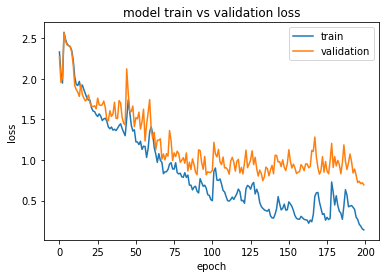

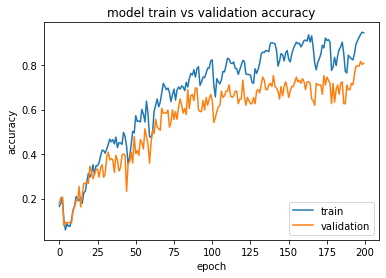

In [34]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig("C:/ML/loss"f"{starttime}.png")
pyplot.show()

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.savefig("C:/ML/accuracy_"f"{starttime}.png")
pyplot.show()

#### Underfit Example
Running this example produces a plot of train and validation loss showing the characteristic of an underfit model. In this case, performance may be improved by increasing the number of training epochs.


<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model.png" width="400">


Running this example shows the characteristic of an underfit model that appears under-provisioned.
In this case, performance may be improved by increasing the capacity of the model, such as the number of memory cells in a hidden layer or number of hidden layers.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model-via-Status.png" width="400">

#### Good Fit Example
Running the example creates a line plot showing the train and validation loss meeting.
Ideally, we would like to see model performance like this if possible, although this may not be possible on challenging problems with a lot of data.

<img src="assets/Diagnostic-Line-Plot-Showing-a-Good-Fit-for-a-Model.png" width="400">

#### Overfit Example
Running this example creates a plot showing the characteristic inflection point in validation loss of an overfit model.
This may be a sign of too many training epochs.
In this case, the model training could be stopped at the inflection point. Alternately, the number of training examples could be increased.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Overfit-Model.png" width="400">

### Evaluate

In [35]:
#model = tf.keras.models.load_model('./tmp/epoch49-0.90-0.39.hdf5')


#bestmodel.evaluate(x=x_test, y=y_test, verbose=2)
model.evaluate(x=x_test, y=y_test, verbose=2)


142/142 - 0s - loss: 0.8799 - accuracy: 0.7465 - precision_4: 0.7591 - recall_4: 0.7324


[0.8798884858547802, 0.74647886, 0.7591241, 0.73239434]

### Save model

In [ ]:
bestmodel.save("sign_lang_recognition_tuned.h5")